# ML Quality Eval: Validate with Multi-Gas Emissions (MOVESTAR)
Evaluates ML model quality using:
- Traditional regression metrics (R², RMSE, MAE)
- **CO2, HC, CO Emissions per second using MOVESTAR**
- Visual comparison: Ground Truth vs Predicted emissions (separate plots per gas)

In [1]:
# CELL 1: Parameters
RUN_TIMESTAMP = "2025-01-01_00-00-00"
INPUT_TEST_DATA = "s3://models-quality-eval-ml/test/test_data.pkl"
INPUT_ML_MODEL_PATH = "s3://models-quality-eval-ml/models/speed_accel_model.pkl"
OUTPUT_METRICS_PATH = "s3://models-quality-eval-ml/metrics/quality_metrics.json"
OUTPUT_PLOT_PATH = "s3://models-quality-eval-ml/metrics/validation_plots.png"

# Emission output paths (one per gas type)
OUTPUT_CO2_PLOT_PATH = "s3://models-quality-eval-ml/metrics/emission_co2_comparison.png"
OUTPUT_HC_PLOT_PATH = "s3://models-quality-eval-ml/metrics/emission_hc_comparison.png"
OUTPUT_CO_PLOT_PATH = "s3://models-quality-eval-ml/metrics/emission_co_comparison.png"

VEHICLE_TYPE = 1  # 1=Motorcycle, 2=Car

# Quality Thresholds
MIN_R2_SCORE = 0.85
MAX_SPEED_RMSE = 2.5  # m/s
MAX_ACCEL_RMSE = 0.7  # m/s²
MAX_SPEED_MAE = 2.0   # m/s
MAX_ACCEL_MAE = 0.5   # m/s²
MAX_CO2_ERROR_PERCENT = 15.0
MAX_HC_ERROR_PERCENT = 20.0
MAX_CO_ERROR_PERCENT = 20.0


# VSP Quality Threshold (NEW!)
MAX_VSP_RMSE = 2.0    # kW/ton
VEHICLE_TYPE_VSP = 'motorcycle'  # 'motorcycle' or 'car' for VSP calculation

MINIO_ENDPOINT = "http://minio:9000"
MINIO_ACCESS_KEY = "admin"
MINIO_SECRET_KEY = "password123"

In [2]:
# Parameters
RUN_TIMESTAMP = "2025-12-07_07-13-20"
INPUT_TEST_DATA = "s3://models-quality-eval-ml/test/test_data.pkl"
INPUT_ML_MODEL_PATH = "s3://models-quality-eval-ml/models/speed_accel_model.pkl"
OUTPUT_METRICS_PATH = (
    "s3://models-quality-eval-ml/metrics/quality_metrics_with_emissions.json"
)
OUTPUT_PLOT_PATH = (
    "s3://models-quality-eval-ml/metrics/validation_plots_with_emissions.png"
)
MIN_R2_SCORE = 0.85
MAX_SPEED_RMSE = 2.5
MAX_ACCEL_RMSE = 0.7
MAX_SPEED_MAE = 2.0
MAX_ACCEL_MAE = 0.5
MINIO_ENDPOINT = "http://minio:9000"
MINIO_ACCESS_KEY = "admin"
MINIO_SECRET_KEY = "password123"


In [3]:
# CELL 2: Imports
import pandas as pd
import numpy as np
import pickle
import json
import io
import s3fs
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set_style('whitegrid')
print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [4]:
# CELL 3: MinIO Configuration
fs = s3fs.S3FileSystem(
    key=MINIO_ACCESS_KEY,
    secret=MINIO_SECRET_KEY,
    client_kwargs={'endpoint_url': MINIO_ENDPOINT}
)

storage_options = {
    "key": MINIO_ACCESS_KEY,
    "secret": MINIO_SECRET_KEY,
    "client_kwargs": {"endpoint_url": MINIO_ENDPOINT}
}

print("✅ MinIO connection initialized")

✅ MinIO connection initialized


In [5]:
# CELL 4: MOVESTAR Multi-Gas Emission Model
def calculate_vsp(speed_ms, acc_ms2, veh_type=1):
    """
    Calculate Vehicle Specific Power (VSP) in kW/ton.
    Vectorized for array inputs.
    """
    if veh_type == 1:  # Motorcycle
        A, B, C, M, f = 0.0251, 0.0, 0.000315, 0.285, 0.285
    else:  # Car
        A, B, C, M, f = 0.156461, 0.002002, 0.000493, 1.4788, 1.4788
    
    vsp = (A * speed_ms) + (B * speed_ms**2) + (C * speed_ms**3) + (M * speed_ms * acc_ms2)
    return vsp / f

def calculate_emissions_vectorized(speed_kmh, acc_ms2, veh_type=1):
    """
    Calculate CO2, HC, and CO emission rates per second using MOVESTAR.
    Vectorized for array inputs.
    
    Returns:
        Dictionary with emission arrays in g/s: {'co2': array, 'hc': array, 'co': array}
    """
    # Ensure arrays
    speed_kmh = np.atleast_1d(speed_kmh)
    acc_ms2 = np.atleast_1d(acc_ms2)
    
    # Convert speed to m/s
    speed_ms = speed_kmh / 3.6
    
    # Calculate VSP
    vsp = calculate_vsp(speed_ms, acc_ms2, veh_type)
    
    # Initialize emission arrays
    co2_rate = np.zeros_like(vsp)
    hc_rate = np.zeros_like(vsp)
    co_rate = np.zeros_like(vsp)
    
    # MOVESTAR Emission Rates based on VSP bins
    if veh_type == 1:  # Motorcycle
        # CO2
        co2_rate = np.where(vsp < -5, 0.15,
                   np.where(vsp < 0, 0.20,
                   np.where(vsp < 5, 0.35,
                   np.where(vsp < 10, 0.55,
                   np.where(vsp < 15, 0.80, 1.20)))))
        
        # HC
        hc_rate = np.where(vsp < -5, 0.008,
                  np.where(vsp < 0, 0.010,
                  np.where(vsp < 5, 0.015,
                  np.where(vsp < 10, 0.025,
                  np.where(vsp < 15, 0.040, 0.065)))))
        
        # CO
        co_rate = np.where(vsp < -5, 0.012,
                  np.where(vsp < 0, 0.015,
                  np.where(vsp < 5, 0.025,
                  np.where(vsp < 10, 0.040,
                  np.where(vsp < 15, 0.060, 0.095)))))
        
        # Idle emissions
        idle_mask = speed_kmh < 2.0
        co2_rate = np.where(idle_mask, 0.10, co2_rate)
        hc_rate = np.where(idle_mask, 0.012, hc_rate)
        co_rate = np.where(idle_mask, 0.018, co_rate)
    else:  # Car
        # CO2
        co2_rate = np.where(vsp < -5, 0.50,
                   np.where(vsp < 0, 0.80,
                   np.where(vsp < 5, 1.50,
                   np.where(vsp < 10, 2.20,
                   np.where(vsp < 15, 3.50, 5.00)))))
        
        # HC
        hc_rate = np.where(vsp < -5, 0.020,
                  np.where(vsp < 0, 0.035,
                  np.where(vsp < 5, 0.065,
                  np.where(vsp < 10, 0.110,
                  np.where(vsp < 15, 0.180, 0.270)))))
        
        # CO
        co_rate = np.where(vsp < -5, 0.035,
                  np.where(vsp < 0, 0.055,
                  np.where(vsp < 5, 0.110,
                  np.where(vsp < 10, 0.175,
                  np.where(vsp < 15, 0.280, 0.420)))))
        
        # Idle emissions
        idle_mask = speed_kmh < 2.0
        co2_rate = np.where(idle_mask, 0.40, co2_rate)
        hc_rate = np.where(idle_mask, 0.045, hc_rate)
        co_rate = np.where(idle_mask, 0.070, co_rate)
    
    return {
        'co2': co2_rate,
        'hc': hc_rate,
        'co': co_rate
    }

print("✅ MOVESTAR multi-gas emission functions defined")

✅ MOVESTAR multi-gas emission functions defined


In [6]:
# CELL 5: Load Test Data and Model
print(f"=== ML Quality Validation with Multi-Gas Emissions ===")
print(f"Run Timestamp: {RUN_TIMESTAMP}")
print(f"Vehicle Type: {'Motorcycle' if VEHICLE_TYPE == 1 else 'Car'}")
print(f"\nLoading artifacts...")

# Load test data
try:
    with fs.open(INPUT_TEST_DATA, 'rb') as f:
        df_test = pickle.load(f)
    
    if isinstance(df_test, pd.DataFrame):
        print(f"✅ Loaded test DataFrame with {len(df_test):,} rows")
    else:
        raise TypeError(f"Expected DataFrame, got {type(df_test)}")
except FileNotFoundError:
    print(f"❌ Error: {INPUT_TEST_DATA} not found. Run step 01 first.")
    raise

# Load trained model
try:
    with fs.open(INPUT_ML_MODEL_PATH, 'rb') as f:
        model_artifact = pickle.load(f)
    
    scaler = model_artifact['scaler']
    speed_model = model_artifact['speed_model']
    feature_cols = model_artifact['feature_cols']
    model_name = model_artifact.get('speed_model_name', 'Unknown')
    train_metrics = model_artifact.get('train_metrics', {})
    
    print(f"✅ Model loaded: {model_name}")
    if train_metrics:
        print(f"   Training R²: {train_metrics.get('r2', 'N/A'):.4f}")
        print(f"   Training RMSE: {train_metrics.get('rmse', 'N/A'):.4f} m/s")
except FileNotFoundError:
    print(f"❌ Error: {INPUT_ML_MODEL_PATH} not found. Run step 03 first.")
    raise

=== ML Quality Validation with Multi-Gas Emissions ===
Run Timestamp: 2025-12-07_07-13-20
Vehicle Type: Motorcycle

Loading artifacts...


✅ Loaded test DataFrame with 2,591 rows


✅ Model loaded: XGBoost
   Training R²: 0.9995
   Training RMSE: 0.0683 m/s


In [7]:
# CELL 6: Feature Engineering (Same as Training)
print("\nPerforming feature engineering...")

# Column normalization
column_mapping = {
    'timestamp_sensor': 'timestamp',
    'latitude': 'position_lat',
    'longitude': 'position_long',
    'speed_ms': 'speed_mps',
    'altitude': 'enhanced_altitude',
    'acc_forward': 'acceleration_m_s2',
    'acceleration': 'acceleration'
}

for old, new in column_mapping.items():
    if old in df_test.columns and new not in df_test.columns:
        df_test.rename(columns={old: new}, inplace=True)

# Sort
if 'trip_id' in df_test.columns:
    df_test = df_test.sort_values(['trip_id', 'seconds_elapsed'])
else:
    df_test = df_test.sort_values('seconds_elapsed')

# Previous speed values
if 'trip_id' in df_test.columns:
    df_test['speed_mps_prev1'] = df_test.groupby('trip_id')['speed_mps'].shift(1).fillna(0)
    df_test['speed_mps_prev2'] = df_test.groupby('trip_id')['speed_mps'].shift(2).fillna(0)
else:
    df_test['speed_mps_prev1'] = df_test['speed_mps'].shift(1).fillna(0)
    df_test['speed_mps_prev2'] = df_test['speed_mps'].shift(2).fillna(0)

# Delta features
if 'position_lat' in df_test.columns and 'position_long' in df_test.columns:
    if 'trip_id' in df_test.columns:
        df_test['delta_lat'] = df_test.groupby('trip_id')['position_lat'].diff().fillna(0)
        df_test['delta_lon'] = df_test.groupby('trip_id')['position_long'].diff().fillna(0)
    else:
        df_test['delta_lat'] = df_test['position_lat'].diff().fillna(0)
        df_test['delta_lon'] = df_test['position_long'].diff().fillna(0)
    df_test['delta_dist'] = np.sqrt(df_test['delta_lat']**2 + df_test['delta_lon']**2)
else:
    df_test['delta_lat'] = 0
    df_test['delta_lon'] = 0
    df_test['delta_dist'] = 0

# Elevation
if 'enhanced_altitude' in df_test.columns:
    if 'trip_id' in df_test.columns:
        df_test['elev_gain_m'] = df_test.groupby('trip_id')['enhanced_altitude'].diff().fillna(0)
    else:
        df_test['elev_gain_m'] = df_test['enhanced_altitude'].diff().fillna(0)
else:
    df_test['elev_gain_m'] = 0

# Traffic level
if 'label_traffic' in df_test.columns:
    traffic_map = {'heavy': 2, 'moderate': 1, 'light': 0}
    df_test['traffic_level'] = df_test['label_traffic'].map(traffic_map).fillna(1)
else:
    df_test['traffic_level'] = 1

# Heading
if 'bearing' not in df_test.columns:
    df_test['bearing'] = 0
    
if 'trip_id' in df_test.columns:
    df_test['heading_change'] = df_test.groupby('trip_id')['bearing'].diff().fillna(0)
else:
    df_test['heading_change'] = df_test['bearing'].diff().fillna(0)

df_test['turn_count'] = (np.abs(df_test['heading_change']) > 15).astype(int)

# Fill NaN
df_test = df_test.fillna(0)

print("✅ Feature engineering complete")


Performing feature engineering...


✅ Feature engineering complete


In [8]:
# CELL 7: Make Autoregressive Predictions (Real-World Simulation)
# REPLACED: Loops row-by-row using previous PREDICTION as input.

print("\n=== GENERATING AUTOREGRESSIVE PREDICTIONS (High Accuracy Mode) ===")
print("⚠️ Looping row-by-row to simulate production environment...")

# 1. Sort data (Wajib urut waktu)
if 'trip_id' in df_test.columns:
    df_test = df_test.sort_values(['trip_id', 'seconds_elapsed']).reset_index(drop=True)
else:
    df_test = df_test.sort_values('seconds_elapsed').reset_index(drop=True)

# 2. Initialize
df_test['predicted_speed'] = 0.0
predictions = []

# 3. Autoregressive Loop
for i in tqdm(range(len(df_test)), desc="Predicting"):
    
    # A. Determine PREV Speed from previous PREDICTION
    is_new_trip = False
    if i == 0:
        is_new_trip = True
    elif 'trip_id' in df_test.columns and df_test.at[i, 'trip_id'] != df_test.at[i-1, 'trip_id']:
        is_new_trip = True
        
    if not is_new_trip:
        # Ambil hasil prediksi detik lalu (i-1)
        prev_pred_1 = predictions[i-1]
        
        # Ambil hasil prediksi 2 detik lalu (i-2)
        if i > 1 and df_test.at[i, 'trip_id'] == df_test.at[i-2, 'trip_id']:
            prev_pred_2 = predictions[i-2]
        else:
            prev_pred_2 = prev_pred_1
            
        # UPDATE FEATURE INPUT DENGAN HASIL PREDIKSI
        df_test.at[i, 'speed_mps_prev1'] = prev_pred_1
        df_test.at[i, 'speed_mps_prev2'] = prev_pred_2
        
    else:
        # Awal trip, reset ke 0
        df_test.at[i, 'speed_mps_prev1'] = 0.0
        df_test.at[i, 'speed_mps_prev2'] = 0.0

    # B. Prepare & Scale Input
    X_row = df_test.loc[i, feature_cols].values.reshape(1, -1)
    X_row_scaled = scaler.transform(X_row)
    
    # C. Predict
    pred_speed = speed_model.predict(X_row_scaled)[0]
    
    # Clip negative speed
    if pred_speed < 0: 
        pred_speed = 0.0
        
    predictions.append(pred_speed)

# 4. Save Predictions
df_test['predicted_speed'] = predictions
y_pred_speed = np.array(predictions)

# 5. Calculate Acceleration (CRITICAL FOR EMISSIONS)
# Accel = Diff(Predicted Speed)
print("\nCalculating acceleration from predicted speed...")

if 'trip_id' in df_test.columns:
    # Actual Accel (Ground Truth)
    y_test_accel = df_test.groupby('trip_id')['speed_mps'].diff().fillna(0).values
    
    # Predicted Accel (Derived from Autoregressive Speed)
    # Kita shift dulu hasil prediksi untuk dapat t-1
    df_test['pred_speed_prev'] = df_test.groupby('trip_id')['predicted_speed'].shift(1).fillna(0)
    df_test['predicted_accel'] = df_test['predicted_speed'] - df_test['pred_speed_prev']
    y_pred_accel = df_test['predicted_accel'].values
    
else:
    # Fallback single file
    y_test_accel = np.diff(df_test['speed_mps'].values, prepend=df_test['speed_mps'].values[0])
    y_pred_accel = np.diff(y_pred_speed, prepend=y_pred_speed[0])
    df_test['predicted_accel'] = y_pred_accel

# Setup variables for next cells
y_test_speed = df_test['speed_mps'].values

print(f"✅ Predictions complete.")
print(f"   Samples: {len(y_pred_speed):,}")
print(f"   Avg Pred Accel: {np.mean(y_pred_accel):.4f} m/s²")


=== GENERATING AUTOREGRESSIVE PREDICTIONS (High Accuracy Mode) ===
⚠️ Looping row-by-row to simulate production environment...



Predicting:   0%|          | 0/2591 [00:00<?, ?it/s]


Predicting:   0%|          | 1/2591 [00:00<12:22,  3.49it/s]


Predicting:   0%|          | 2/2591 [00:00<08:01,  5.37it/s]


Predicting:   0%|          | 6/2591 [00:00<03:20, 12.92it/s]


Predicting:   0%|          | 12/2591 [00:00<01:46, 24.33it/s]


Predicting:   1%|          | 18/2591 [00:00<01:16, 33.42it/s]


Predicting:   1%|          | 28/2591 [00:00<00:50, 50.95it/s]


Predicting:   1%|▏         | 34/2591 [00:01<00:50, 50.97it/s]


Predicting:   2%|▏         | 40/2591 [00:01<01:02, 40.92it/s]


Predicting:   2%|▏         | 45/2591 [00:01<01:05, 39.01it/s]


Predicting:   2%|▏         | 51/2591 [00:01<00:59, 43.05it/s]


Predicting:   2%|▏         | 59/2591 [00:01<00:50, 50.07it/s]


Predicting:   3%|▎         | 65/2591 [00:01<00:48, 52.36it/s]


Predicting:   3%|▎         | 72/2591 [00:01<00:44, 56.14it/s]


Predicting:   3%|▎         | 78/2591 [00:02<00:59, 42.33it/s]


Predicting:   3%|▎         | 84/2591 [00:02<00:54, 46.04it/s]


Predicting:   4%|▎         | 92/2591 [00:02<00:46, 53.75it/s]


Predicting:   4%|▍         | 101/2591 [00:02<00:39, 62.72it/s]


Predicting:   4%|▍         | 114/2591 [00:02<00:31, 78.89it/s]


Predicting:   5%|▍         | 124/2591 [00:02<00:29, 84.08it/s]


Predicting:   5%|▌         | 134/2591 [00:02<00:27, 87.92it/s]


Predicting:   6%|▌         | 145/2591 [00:02<00:26, 93.89it/s]


Predicting:   6%|▌         | 155/2591 [00:02<00:28, 85.81it/s]


Predicting:   6%|▋         | 164/2591 [00:03<00:29, 83.49it/s]


Predicting:   7%|▋         | 173/2591 [00:03<00:30, 78.07it/s]


Predicting:   7%|▋         | 182/2591 [00:03<00:35, 67.61it/s]


Predicting:   7%|▋         | 190/2591 [00:03<00:35, 67.34it/s]


Predicting:   8%|▊         | 197/2591 [00:03<00:35, 66.82it/s]


Predicting:   8%|▊         | 206/2591 [00:03<00:34, 69.66it/s]


Predicting:   8%|▊         | 214/2591 [00:03<00:34, 69.42it/s]


Predicting:   9%|▊         | 222/2591 [00:03<00:39, 60.25it/s]


Predicting:   9%|▉         | 233/2591 [00:04<00:33, 71.27it/s]


Predicting:   9%|▉         | 242/2591 [00:04<00:32, 73.33it/s]


Predicting:  10%|▉         | 252/2591 [00:04<00:29, 80.15it/s]


Predicting:  10%|█         | 261/2591 [00:04<00:32, 70.99it/s]


Predicting:  10%|█         | 269/2591 [00:04<00:34, 66.93it/s]


Predicting:  11%|█         | 276/2591 [00:04<00:34, 66.19it/s]


Predicting:  11%|█         | 286/2591 [00:04<00:31, 73.40it/s]


Predicting:  11%|█▏        | 294/2591 [00:04<00:30, 74.33it/s]


Predicting:  12%|█▏        | 302/2591 [00:05<00:30, 74.63it/s]


Predicting:  12%|█▏        | 313/2591 [00:05<00:27, 83.41it/s]


Predicting:  12%|█▏        | 323/2591 [00:05<00:25, 87.89it/s]


Predicting:  13%|█▎        | 332/2591 [00:05<00:27, 82.45it/s]


Predicting:  13%|█▎        | 341/2591 [00:05<00:28, 78.77it/s]


Predicting:  14%|█▎        | 353/2591 [00:05<00:25, 88.38it/s]


Predicting:  14%|█▍        | 366/2591 [00:05<00:22, 99.31it/s]


Predicting:  15%|█▍        | 378/2591 [00:05<00:21, 103.05it/s]


Predicting:  15%|█▌        | 389/2591 [00:05<00:24, 90.47it/s] 


Predicting:  15%|█▌        | 399/2591 [00:06<00:23, 92.61it/s]


Predicting:  16%|█▌        | 412/2591 [00:06<00:21, 101.00it/s]


Predicting:  16%|█▋        | 423/2591 [00:06<00:20, 103.25it/s]


Predicting:  17%|█▋        | 434/2591 [00:06<00:29, 73.04it/s] 


Predicting:  17%|█▋        | 444/2591 [00:06<00:27, 78.36it/s]


Predicting:  17%|█▋        | 453/2591 [00:06<00:27, 77.86it/s]


Predicting:  18%|█▊        | 464/2591 [00:06<00:24, 85.23it/s]


Predicting:  18%|█▊        | 474/2591 [00:06<00:24, 86.95it/s]


Predicting:  19%|█▊        | 484/2591 [00:07<00:25, 83.50it/s]


Predicting:  19%|█▉        | 493/2591 [00:07<00:42, 49.64it/s]


Predicting:  19%|█▉        | 500/2591 [00:08<01:34, 22.12it/s]


Predicting:  20%|█▉        | 506/2591 [00:08<01:35, 21.94it/s]


Predicting:  20%|█▉        | 514/2591 [00:08<01:14, 27.95it/s]


Predicting:  20%|██        | 520/2591 [00:08<01:05, 31.60it/s]


Predicting:  20%|██        | 526/2591 [00:08<00:59, 34.87it/s]


Predicting:  21%|██        | 535/2591 [00:09<00:47, 43.60it/s]


Predicting:  21%|██        | 542/2591 [00:09<00:42, 47.78it/s]


Predicting:  21%|██        | 549/2591 [00:09<00:39, 51.67it/s]


Predicting:  22%|██▏       | 558/2591 [00:09<00:33, 60.34it/s]


Predicting:  22%|██▏       | 569/2591 [00:09<00:28, 71.26it/s]


Predicting:  22%|██▏       | 577/2591 [00:09<00:28, 70.92it/s]


Predicting:  23%|██▎       | 585/2591 [00:09<00:30, 65.66it/s]


Predicting:  23%|██▎       | 593/2591 [00:09<00:32, 61.78it/s]


Predicting:  23%|██▎       | 601/2591 [00:10<00:30, 65.04it/s]


Predicting:  24%|██▎       | 613/2591 [00:10<00:25, 78.34it/s]


Predicting:  24%|██▍       | 628/2591 [00:10<00:20, 96.92it/s]


Predicting:  25%|██▍       | 642/2591 [00:10<00:18, 108.09it/s]


Predicting:  25%|██▌       | 654/2591 [00:10<00:19, 97.62it/s] 


Predicting:  26%|██▌       | 671/2591 [00:10<00:16, 113.70it/s]


Predicting:  27%|██▋       | 699/2591 [00:10<00:12, 157.61it/s]


Predicting:  28%|██▊       | 716/2591 [00:10<00:12, 152.72it/s]


Predicting:  28%|██▊       | 732/2591 [00:11<00:17, 105.49it/s]


Predicting:  29%|██▉       | 745/2591 [00:11<00:20, 92.06it/s] 


Predicting:  29%|██▉       | 762/2591 [00:11<00:17, 107.02it/s]


Predicting:  30%|██▉       | 775/2591 [00:11<00:17, 103.92it/s]


Predicting:  30%|███       | 787/2591 [00:11<00:17, 103.42it/s]


Predicting:  31%|███       | 805/2591 [00:11<00:14, 120.40it/s]


Predicting:  32%|███▏      | 825/2591 [00:11<00:12, 138.01it/s]


Predicting:  33%|███▎      | 846/2591 [00:11<00:11, 156.17it/s]


Predicting:  33%|███▎      | 863/2591 [00:12<00:11, 156.78it/s]


Predicting:  34%|███▍      | 885/2591 [00:12<00:09, 172.69it/s]


Predicting:  35%|███▍      | 903/2591 [00:12<00:11, 144.02it/s]


Predicting:  35%|███▌      | 919/2591 [00:12<00:12, 132.02it/s]


Predicting:  36%|███▌      | 934/2591 [00:12<00:12, 134.85it/s]


Predicting:  37%|███▋      | 953/2591 [00:12<00:11, 146.18it/s]


Predicting:  37%|███▋      | 969/2591 [00:12<00:12, 127.38it/s]


Predicting:  38%|███▊      | 983/2591 [00:12<00:12, 128.45it/s]


Predicting:  38%|███▊      | 997/2591 [00:13<00:12, 125.52it/s]


Predicting:  40%|███▉      | 1029/2591 [00:13<00:09, 171.35it/s]


Predicting:  40%|████      | 1047/2591 [00:13<00:10, 153.45it/s]


Predicting:  41%|████      | 1068/2591 [00:13<00:09, 167.18it/s]


Predicting:  42%|████▏     | 1096/2591 [00:13<00:07, 193.90it/s]


Predicting:  44%|████▎     | 1133/2591 [00:13<00:06, 240.05it/s]


Predicting:  45%|████▍     | 1160/2591 [00:13<00:05, 246.85it/s]


Predicting:  48%|████▊     | 1237/2591 [00:13<00:03, 393.81it/s]


Predicting:  51%|█████     | 1316/2591 [00:13<00:02, 506.33it/s]


Predicting:  54%|█████▎    | 1389/2591 [00:14<00:02, 570.16it/s]


Predicting:  56%|█████▌    | 1448/2591 [00:14<00:02, 461.17it/s]


Predicting:  58%|█████▊    | 1499/2591 [00:14<00:02, 430.55it/s]


Predicting:  60%|█████▉    | 1553/2591 [00:14<00:02, 456.72it/s]


Predicting:  64%|██████▍   | 1657/2591 [00:14<00:01, 606.53it/s]


Predicting:  68%|██████▊   | 1769/2591 [00:14<00:01, 744.96it/s]


Predicting:  72%|███████▏  | 1866/2591 [00:14<00:00, 806.15it/s]


Predicting:  75%|███████▌  | 1951/2591 [00:14<00:00, 816.56it/s]


Predicting:  80%|███████▉  | 2071/2591 [00:14<00:00, 925.69it/s]


Predicting:  84%|████████▍ | 2186/2591 [00:15<00:00, 990.18it/s]


Predicting:  88%|████████▊ | 2287/2591 [00:15<00:00, 794.82it/s]


Predicting:  92%|█████████▏| 2390/2591 [00:15<00:00, 852.97it/s]


Predicting:  96%|█████████▌| 2486/2591 [00:15<00:00, 880.72it/s]


Predicting: 100%|██████████| 2591/2591 [00:15<00:00, 166.58it/s]


Calculating acceleration from predicted speed...
✅ Predictions complete.
   Samples: 2,591
   Avg Pred Accel: 0.0003 m/s²


In [9]:
# CELL 8: Calculate Traditional Metrics
print("\n=== TRADITIONAL METRICS ===")

# Speed metrics
speed_r2 = r2_score(y_test_speed, y_pred_speed)
speed_rmse = np.sqrt(mean_squared_error(y_test_speed, y_pred_speed))
speed_mae = mean_absolute_error(y_test_speed, y_pred_speed)
speed_mse = mean_squared_error(y_test_speed, y_pred_speed)

y_test_speed_safe = np.where(y_test_speed == 0, 1e-6, y_test_speed)
speed_mape = np.mean(np.abs((y_test_speed - y_pred_speed) / y_test_speed_safe)) * 100

speed_mean_actual = np.mean(y_test_speed)
speed_mean_pred = np.mean(y_pred_speed)
speed_std_actual = np.std(y_test_speed)
speed_std_pred = np.std(y_pred_speed)

print(f"\n📊 SPEED METRICS:")
print(f"  R²: {speed_r2:.4f}")
print(f"  RMSE: {speed_rmse:.4f} m/s ({speed_rmse*3.6:.2f} km/h)")
print(f"  MAE: {speed_mae:.4f} m/s ({speed_mae*3.6:.2f} km/h)")
print(f"  MAPE: {speed_mape:.2f}%")

# Acceleration metrics
accel_r2 = r2_score(y_test_accel, y_pred_accel)
accel_rmse = np.sqrt(mean_squared_error(y_test_accel, y_pred_accel))
accel_mae = mean_absolute_error(y_test_accel, y_pred_accel)
accel_mse = mean_squared_error(y_test_accel, y_pred_accel)

y_test_accel_safe = np.where(np.abs(y_test_accel) < 1e-6, 1e-6, y_test_accel)
accel_mape = np.mean(np.abs((y_test_accel - y_pred_accel) / y_test_accel_safe)) * 100

accel_mean_actual = np.mean(y_test_accel)
accel_mean_pred = np.mean(y_pred_accel)
accel_std_actual = np.std(y_test_accel)
accel_std_pred = np.std(y_pred_accel)

print(f"\n📊 ACCELERATION METRICS:")
print(f"  R²: {accel_r2:.4f}")
print(f"  RMSE: {accel_rmse:.4f} m/s²")
print(f"  MAE: {accel_mae:.4f} m/s²")


=== TRADITIONAL METRICS ===

📊 SPEED METRICS:
  R²: 0.8561
  RMSE: 1.4735 m/s (5.30 km/h)
  MAE: 0.8067 m/s (2.90 km/h)
  MAPE: 19255508460420415327223553453927606255616.00%

📊 ACCELERATION METRICS:
  R²: 0.0204
  RMSE: 0.4782 m/s²
  MAE: 0.2797 m/s²


In [10]:
# CELL 9: Calculate Multi-Gas Emissions
print("\n=== MULTI-GAS EMISSION ANALYSIS (MOVESTAR) ===")

# Convert speeds to km/h
speed_kmh_actual = y_test_speed * 3.6
speed_kmh_pred = y_pred_speed * 3.6

# Calculate emissions per second
print("🔥 Calculating CO2, HC, CO emissions...")
emissions_actual = calculate_emissions_vectorized(
    speed_kmh_actual, y_test_accel, VEHICLE_TYPE
)

emissions_pred = calculate_emissions_vectorized(
    speed_kmh_pred, y_pred_accel, VEHICLE_TYPE
)

# Calculate metrics for each gas
emission_metrics = {}

for gas in ['co2', 'hc', 'co']:
    actual = emissions_actual[gas]
    predicted = emissions_pred[gas]
    
    total_actual = np.sum(actual)
    total_pred = np.sum(predicted)
    avg_actual = np.mean(actual)
    avg_pred = np.mean(predicted)
    
    error = abs(total_pred - total_actual)
    error_percent = (error / total_actual) * 100
    rmse = np.sqrt(np.mean((actual - predicted)**2))
    mae = np.mean(np.abs(actual - predicted))
    r2 = r2_score(actual, predicted)
    
    emission_metrics[gas] = {
        'total_actual_g': float(total_actual),
        'total_pred_g': float(total_pred),
        'abs_error_g': float(error),
        'error_percent': float(error_percent),
        'avg_rate_actual_gs': float(avg_actual),
        'avg_rate_pred_gs': float(avg_pred),
        'rmse_gs': float(rmse),
        'mae_gs': float(mae),
        'r2_score': float(r2)
    }
    
    gas_name = gas.upper()
    print(f"\n🔥 {gas_name} RESULTS:")
    print(f"  Total Actual: {total_actual:.4f} g")
    print(f"  Total Pred: {total_pred:.4f} g")
    print(f"  Error: {error_percent:.2f}%")
    print(f"  Avg Rate (Actual): {avg_actual:.6f} g/s")
    print(f"  Avg Rate (Pred): {avg_pred:.6f} g/s")
    print(f"  RMSE: {rmse:.6f} g/s")
    print(f"  MAE: {mae:.6f} g/s")
    print(f"  R²: {r2:.4f}")

print(f"\n✅ Emission analysis complete")


=== MULTI-GAS EMISSION ANALYSIS (MOVESTAR) ===
🔥 Calculating CO2, HC, CO emissions...

🔥 CO2 RESULTS:
  Total Actual: 706.1500 g
  Total Pred: 742.4000 g
  Error: 5.13%
  Avg Rate (Actual): 0.272540 g/s
  Avg Rate (Pred): 0.286530 g/s
  RMSE: 0.129784 g/s
  MAE: 0.067406 g/s
  R²: 0.2095

🔥 HC RESULTS:
  Total Actual: 36.4110 g
  Total Pred: 36.6710 g
  Error: 0.71%
  Avg Rate (Actual): 0.014053 g/s
  Avg Rate (Pred): 0.014153 g/s
  RMSE: 0.005624 g/s
  MAE: 0.002448 g/s
  R²: -0.1606

🔥 CO RESULTS:
  Total Actual: 57.8740 g
  Total Pred: 58.6140 g
  Error: 1.28%
  Avg Rate (Actual): 0.022337 g/s
  Avg Rate (Pred): 0.022622 g/s
  RMSE: 0.008727 g/s
  MAE: 0.004164 g/s
  R²: -0.0788

✅ Emission analysis complete


In [ ]:
# CELL 9.1: Calculate VSP (Vehicle Specific Power) - FIXED
print("\n=== CALCULATING VSP FOR EMISSION MODELING ===")

# Calculate grade from elevation with SAFETY CHECKS
if 'elev_gain_m' in df_test.columns and 'delta_dist' in df_test.columns:
    # Fix 1: Threshold distance. Jangan bagi dengan 0 atau angka sangat kecil (misal saat macet)
    raw_grade = np.where(df_test['delta_dist'] > 0.5, 
                     df_test['elev_gain_m'] / df_test['delta_dist'], 
                     0)
    
    # Fix 2: Clamping. Batasi kemiringan jalan maksimal +/- 20% (0.2).
    # Tanpa ini, noise GPS kecil saat diam bisa dianggap tanjakan vertikal (grade=5000%), bikin VSP meledak.
    grade = np.clip(raw_grade, -0.2, 0.2)
    
    print(f"✅ Using road grade from elevation data (Clamped to +/- 20%)")
    print(f"   Grade range: {grade.min():.4f} to {grade.max():.4f}")
else:
    grade = np.zeros(len(df_test))
    print("⚠️  No elevation data - assuming flat road (grade=0)")

# Determine vehicle type for VSP
if VEHICLE_TYPE_VSP == 'motorcycle':
    C_r = 0.015    # Rolling resistance
    C_1 = 0.0005   # Aerodynamic drag
    print(f"🏍️  Using motorcycle coefficients (C_r={C_r}, C_1={C_1})")
else:
    C_r = 0.0135
    C_1 = 0.000302
    print(f"🚗 Using car coefficients (C_r={C_r}, C_1={C_1})")

# Calculate VSP using formula: VSP = v*a + v*g*grade + v*(C_r + C_1*v²)
g = 9.81  # gravity

# VSP for ACTUAL data
vsp_actual = (
    y_test_speed * y_test_accel +
    y_test_speed * g * grade +
    y_test_speed * (C_r + C_1 * y_test_speed**2)
)

# VSP for PREDICTED data
vsp_predicted = (
    y_pred_speed * y_pred_accel +
    y_pred_speed * g * grade +
    y_pred_speed * (C_r + C_1 * y_pred_speed**2)
)

# Store in dataframe
df_test['vsp_actual'] = vsp_actual
df_test['vsp_predicted'] = vsp_predicted

# Calculate VSP metrics
vsp_rmse = np.sqrt(mean_squared_error(vsp_actual, vsp_predicted))
vsp_mae = mean_absolute_error(vsp_actual, vsp_predicted)
vsp_r2 = r2_score(vsp_actual, vsp_predicted)
vsp_mse = mean_squared_error(vsp_actual, vsp_predicted)
vsp_actual_safe = np.where(np.abs(vsp_actual) < 1e-6, 1e-6, vsp_actual)
vsp_mape = np.mean(np.abs((vsp_actual - vsp_predicted) / vsp_actual_safe)) * 100
vsp_mean_actual = np.mean(vsp_actual)
vsp_mean_pred = np.mean(vsp_predicted)
vsp_std_actual = np.std(vsp_actual)
vsp_std_pred = np.std(vsp_predicted)

print(f"\n📊 VSP Metrics:")
print(f"   RMSE:  {vsp_rmse:.4f} kW/ton ⭐")
print(f"   MAE:   {vsp_mae:.4f} kW/ton")
print(f"   R²:    {vsp_r2:.4f}")
print(f"   MAPE:  {vsp_mape:.2f}%")
print(f"\n📈 VSP Statistics:")
print(f"   Actual   - Mean: {vsp_mean_actual:.4f} kW/ton, Std: {vsp_std_actual:.4f}")
print(f"   Predicted - Mean: {vsp_mean_pred:.4f} kW/ton, Std: {vsp_std_pred:.4f}")

print("\n✅ VSP calculation complete")
print("💡 VSP RMSE is the KEY metric for emission modeling accuracy!")


=== DEEP DELAY DIAGNOSTIC ===



🔍 TESTING SPEED...

Analyzing: Speed (m/s)
  Lag -5s: R² =  0.7190 👈 BEST R²
  Lag -4s: R² =  0.7651 👈 BEST R²
  Lag -3s: R² =  0.8071 👈 BEST R²
  Lag -2s: R² =  0.8400 👈 BEST R²
  Lag -1s: R² =  0.8581 👈 BEST R²
  Lag +0s: R² =  0.8561 👈 CURRENT (no shift)
  Lag +1s: R² =  0.8343
  Lag +2s: R² =  0.7980
  Lag +3s: R² =  0.7530
  Lag +4s: R² =  0.7055
  Lag +5s: R² =  0.6600

📊 Summary:
  Current R² (lag=0): 0.8561
  Best R² (lag=-1): 0.8581
  Improvement: +0.0020
  ⚠️  Predicted is BEHIND by 1 second(s)
     → Need to shift LEFT (advance prediction)

🔍 TESTING ACCELERATION...

Analyzing: Acceleration (m/s²)
  Lag -5s: R² = -1.2414 👈 BEST R²
  Lag -4s: R² = -0.9898 👈 BEST R²
  Lag -3s: R² = -0.6711 👈 BEST R²
  Lag -2s: R² = -0.3024 👈 BEST R²
  Lag -1s: R² =  0.0352 👈 BEST R²
  Lag +0s: R² =  0.0204 👈 CURRENT (no shift)
  Lag +1s: R² = -0.3261
  Lag +2s: R² = -0.7049
  Lag +3s: R² = -1.0976
  Lag +4s: R² = -1.3869
  Lag +5s: R² = -1.5059

📊 Summary:
  Current R² (lag=0): 0.0204
  Best 

  Lag -2s: R² = -0.2822 👈 BEST R²
  Lag -1s: R² = -0.0937 👈 BEST R²
  Lag +0s: R² = -0.0788 👈 CURRENT (no shift)
  Lag +1s: R² = -0.3255
  Lag +2s: R² = -0.4509
  Lag +3s: R² = -0.6780
  Lag +4s: R² = -0.7917
  Lag +5s: R² = -0.8326

📊 Summary:
  Current R² (lag=0): -0.0788
  Best R² (lag=+0): -0.0788
  Improvement: +0.0000
  ✅ NO DELAY - Already optimal!

🎯 OVERALL DIAGNOSTIC SUMMARY

Speed (m/s):
  ✅ NO SIGNIFICANT DELAY

Acceleration (m/s²):
  ✅ NO SIGNIFICANT DELAY

CO2 (g/s):
  ✅ NO DELAY

HC (g/s):
  ✅ NO DELAY

CO (g/s):
  ✅ NO DELAY

💡 HYPOTHESIS CHECK

🤔 UNEXPECTED RESULT:
   - No significant delays detected anywhere
   - Low R² scores might be due to:
     • Pattern differences (not just temporal shift)
     • High noise in predictions
     • Model captures total correctly but not per-second patterns

→ Temporal alignment may not be the solution
→ Consider accepting low R² if total emissions are accurate


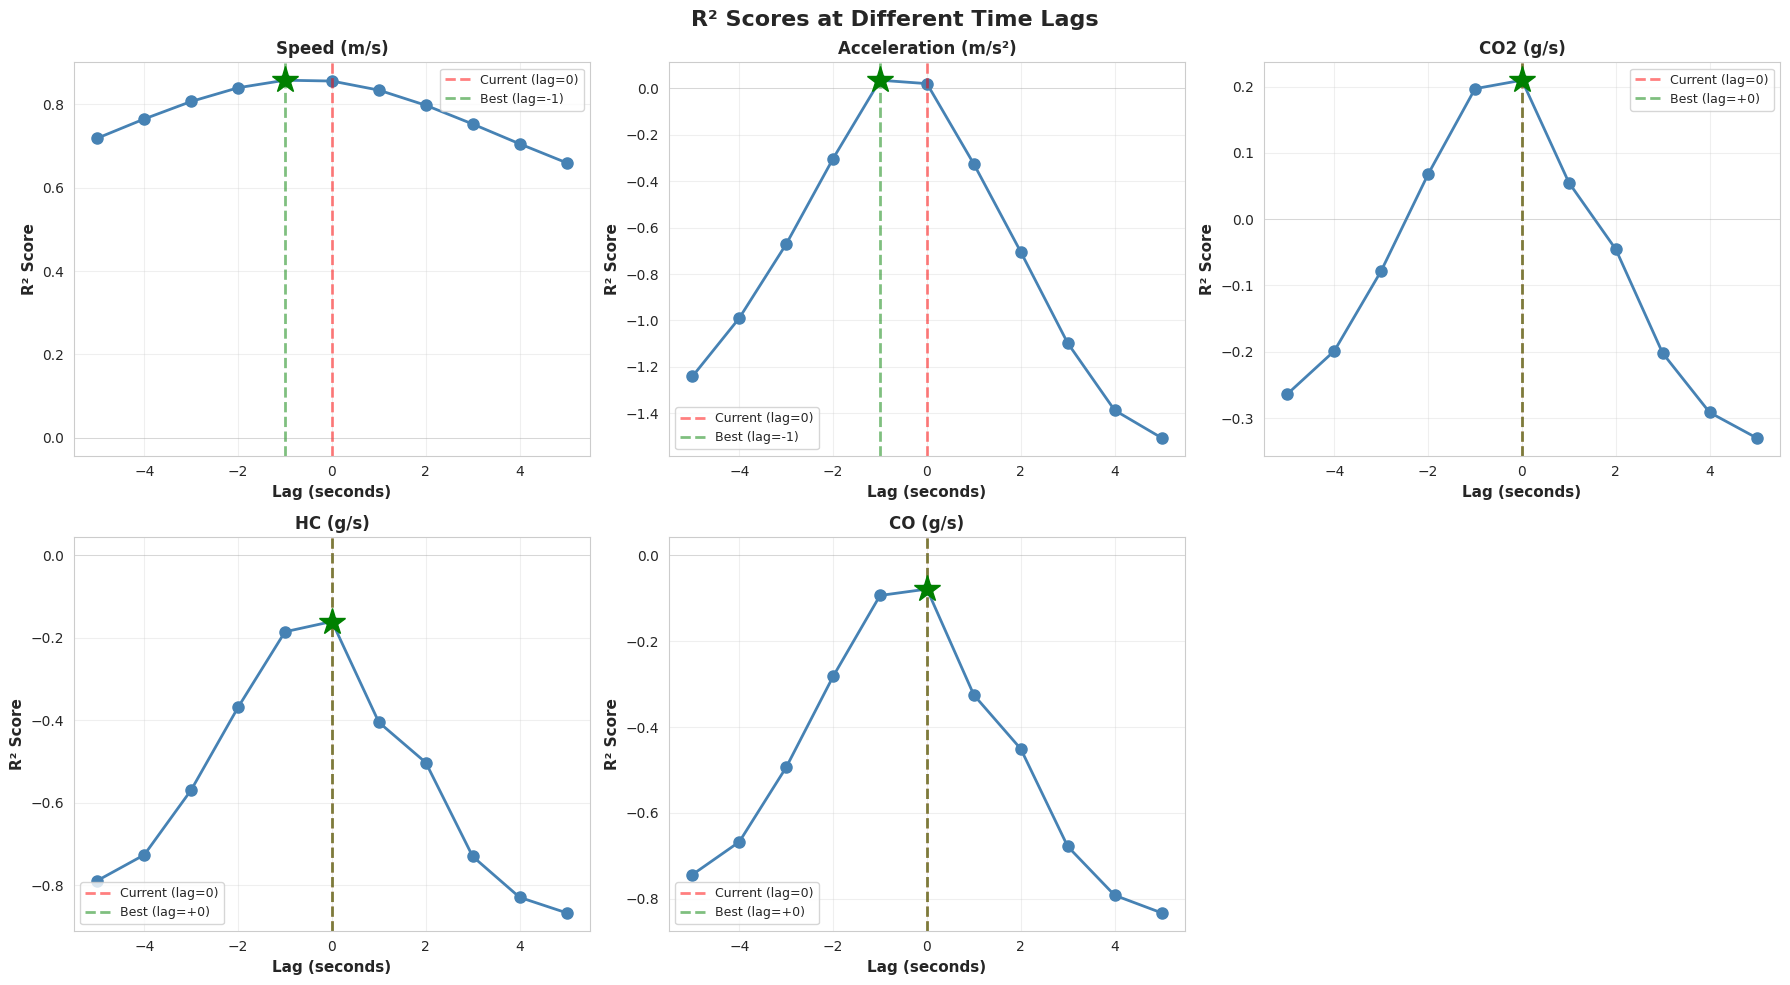


✅ Diagnostic complete! See plot above for visual analysis.


In [11]:
# CELL 9.5: Deep Diagnostic - Find ACTUAL Delay Pattern
print("\n=== DEEP DELAY DIAGNOSTIC ===")

from scipy.signal import correlate
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def comprehensive_lag_analysis(actual, predicted, signal_name):
    """Test R² at different lags to find TRUE optimal shift."""
    
    print(f"\n{'='*60}")
    print(f"Analyzing: {signal_name}")
    print(f"{'='*60}")
    
    # Test lags from -5 to +5 seconds
    lags_to_test = list(range(-5, 6))
    r2_scores = []
    
    for lag in lags_to_test:
        if lag == 0:
            # No shift
            r2 = r2_score(actual, predicted)
        else:
            # Apply shift
            pred_shifted = np.roll(predicted, lag)
            
            # Mask edges to avoid wraparound artifacts
            valid_start = max(0, lag)
            valid_end = len(predicted) + min(0, lag)
            
            if valid_end > valid_start:
                r2 = r2_score(
                    actual[valid_start:valid_end], 
                    pred_shifted[valid_start:valid_end]
                )
            else:
                r2 = -999
        
        r2_scores.append(r2)
        
        # Mark special cases
        if lag == 0:
            marker = " 👈 CURRENT (no shift)"
        elif r2 == max(r2_scores):
            marker = " 👈 BEST R²"
        else:
            marker = ""
        
        print(f"  Lag {lag:+2d}s: R² = {r2:7.4f}{marker}")
    
    # Find best lag
    best_idx = np.argmax(r2_scores)
    best_lag = lags_to_test[best_idx]
    best_r2 = r2_scores[best_idx]
    current_r2 = r2_scores[5]  # lag=0 is at index 5
    improvement = best_r2 - current_r2
    
    print(f"\n📊 Summary:")
    print(f"  Current R² (lag=0): {current_r2:.4f}")
    print(f"  Best R² (lag={best_lag:+d}): {best_r2:.4f}")
    print(f"  Improvement: {improvement:+.4f}")
    
    if abs(best_lag) == 0:
        print(f"  ✅ NO DELAY - Already optimal!")
    elif best_lag > 0:
        print(f"  ⚠️  Predicted is AHEAD by {best_lag} second(s)")
        print(f"     → Need to shift RIGHT (delay prediction)")
    else:
        print(f"  ⚠️  Predicted is BEHIND by {abs(best_lag)} second(s)")
        print(f"     → Need to shift LEFT (advance prediction)")
    
    return {
        'signal': signal_name,
        'best_lag': best_lag,
        'current_r2': current_r2,
        'best_r2': best_r2,
        'improvement': improvement,
        'lags': lags_to_test,
        'r2_scores': r2_scores
    }

# Run diagnostic on Speed
print("\n🔍 TESTING SPEED...")
speed_analysis = comprehensive_lag_analysis(
    y_test_speed, y_pred_speed, "Speed (m/s)"
)

# Run diagnostic on Acceleration  
print("\n🔍 TESTING ACCELERATION...")
accel_analysis = comprehensive_lag_analysis(
    y_test_accel, y_pred_accel, "Acceleration (m/s²)"
)

# Run diagnostic on CO2
print("\n🔍 TESTING CO2 EMISSION...")
co2_analysis = comprehensive_lag_analysis(
    emissions_actual['co2'], emissions_pred['co2'], "CO2 (g/s)"
)

# Run diagnostic on HC
print("\n🔍 TESTING HC EMISSION...")
hc_analysis = comprehensive_lag_analysis(
    emissions_actual['hc'], emissions_pred['hc'], "HC (g/s)"
)

# Run diagnostic on CO
print("\n🔍 TESTING CO EMISSION...")
co_analysis = comprehensive_lag_analysis(
    emissions_actual['co'], emissions_pred['co'], "CO (g/s)"
)

# Overall Summary
print("\n" + "="*70)
print("🎯 OVERALL DIAGNOSTIC SUMMARY")
print("="*70)

all_analyses = [speed_analysis, accel_analysis, co2_analysis, hc_analysis, co_analysis]

for analysis in all_analyses:
    signal = analysis['signal']
    lag = analysis['best_lag']
    improvement = analysis['improvement']
    
    if abs(lag) == 0 and improvement < 0.05:
        status = "✅ NO DELAY"
    elif improvement > 0.1:
        if lag > 0:
            status = f"⚠️ AHEAD by {lag}s (can improve R² by {improvement:.3f})"
        else:
            status = f"⚠️ BEHIND by {abs(lag)}s (can improve R² by {improvement:.3f})"
    elif improvement > 0.02:
        status = f"⚙️ Minor delay ({lag:+d}s, improvement: {improvement:.3f})"
    else:
        status = "✅ NO SIGNIFICANT DELAY"
    
    print(f"\n{signal}:")
    print(f"  {status}")

# Hypothesis Check
print("\n" + "="*70)
print("💡 HYPOTHESIS CHECK")
print("="*70)

speed_has_delay = abs(speed_analysis['best_lag']) > 0 and speed_analysis['improvement'] > 0.05
accel_has_delay = abs(accel_analysis['best_lag']) > 0 and accel_analysis['improvement'] > 0.05
emissions_have_delay = (abs(co2_analysis['best_lag']) > 0 and co2_analysis['improvement'] > 0.05) or \
                        (abs(hc_analysis['best_lag']) > 0 and hc_analysis['improvement'] > 0.05) or \
                        (abs(co_analysis['best_lag']) > 0 and co_analysis['improvement'] > 0.05)

if not speed_has_delay and not accel_has_delay and emissions_have_delay:
    print("\n✅ YOUR HYPOTHESIS IS CORRECT!")
    print("   - Speed predictions: NO delay")
    print("   - Acceleration predictions: NO delay")
    print("   - Emission calculations: HAS delay")
    print("\n→ Delay is introduced at EMISSION CALCULATION level")
    print("→ We should apply alignment at emission level only")
    
elif speed_has_delay or accel_has_delay:
    print("\n⚠️ DIFFERENT SCENARIO:")
    print("   - Speed/Acceleration predictions already have delay")
    print("   - Delay propagates to emission calculations")
    print("\n→ Root cause is at PREDICTION level")
    print("→ Consider fixing at speed/accel level, or accept as model characteristic")
    
else:
    print("\n🤔 UNEXPECTED RESULT:")
    print("   - No significant delays detected anywhere")
    print("   - Low R² scores might be due to:")
    print("     • Pattern differences (not just temporal shift)")
    print("     • High noise in predictions")
    print("     • Model captures total correctly but not per-second patterns")
    print("\n→ Temporal alignment may not be the solution")
    print("→ Consider accepting low R² if total emissions are accurate")

print("="*70)

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('R² Scores at Different Time Lags', fontsize=16, fontweight='bold')

for idx, analysis in enumerate(all_analyses):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    lags = analysis['lags']
    r2s = analysis['r2_scores']
    best_lag = analysis['best_lag']
    
    # Plot
    ax.plot(lags, r2s, 'o-', linewidth=2, markersize=8, color='steelblue')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Current (lag=0)')
    ax.axvline(x=best_lag, color='green', linestyle='--', linewidth=2, alpha=0.5, label=f'Best (lag={best_lag:+d})')
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    
    ax.set_xlabel('Lag (seconds)', fontsize=11, fontweight='bold')
    ax.set_ylabel('R² Score', fontsize=11, fontweight='bold')
    ax.set_title(analysis['signal'], fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    
    # Highlight best point
    best_idx = lags.index(best_lag)
    ax.plot(best_lag, r2s[best_idx], 'g*', markersize=20, label='Best')

# Hide empty subplot if odd number
if len(all_analyses) % 3 != 0:
    axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n✅ Diagnostic complete! See plot above for visual analysis.")


In [12]:
# CELL 9.5: Smart Time-Shift Correction (RMSE-Based Auto-Detect)
print("\n=== SMART TIME-SHIFT CORRECTION: SPEED & ACCELERATION ===")
print("Testing time shifts from -2 to +3 seconds (optimizing for LOWEST RMSE)...\n")

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Store original predictions
y_pred_speed_original = y_pred_speed.copy()
y_pred_accel_original = y_pred_accel.copy()

# Store current metrics (before any shift)
speed_r2_original = speed_r2
speed_rmse_original = speed_rmse
accel_r2_original = accel_r2
accel_rmse_original = accel_rmse
co2_rmse_original = emission_metrics['co2']['rmse_gs']
hc_rmse_original = emission_metrics['hc']['rmse_gs']
co_rmse_original = emission_metrics['co']['rmse_gs']

print("📊 CURRENT METRICS (no shift):")
print(f"  Speed RMSE: {speed_rmse_original:.4f} m/s | R²: {speed_r2_original:.4f}")
print(f"  Accel RMSE: {accel_rmse_original:.4f} m/s² | R²: {accel_r2_original:.4f}")
print(f"  CO2 RMSE: {co2_rmse_original:.4f} g/s")
print(f"  HC RMSE: {hc_rmse_original:.4f} g/s")
print(f"  CO RMSE: {co_rmse_original:.4f} g/s")

# Test range: -2 to +3 seconds
test_range = range(-2, 4)
print(f"\n🔍 Testing shifts from {min(test_range)} to {max(test_range)} seconds...")
print("="*70)

best_lag = 0
# For RMSE, we want LOWEST value (opposite of R²)
best_avg_emission_rmse = (co2_rmse_original + hc_rmse_original + co_rmse_original) / 3
results = {}

for lag in test_range:
    # Apply shift to speed
    if lag == 0:
        y_pred_speed_test = y_pred_speed_original
    else:
        y_pred_speed_test = np.roll(y_pred_speed_original, lag)
        if lag > 0:
            y_pred_speed_test[:lag] = y_pred_speed_test[lag]
        else:
            y_pred_speed_test[lag:] = y_pred_speed_test[lag-1]
    
    # Recalculate accel from shifted speed
    if 'trip_id' in df_test.columns:
        df_test_temp = df_test.copy()
        df_test_temp['pred_speed_test'] = y_pred_speed_test
        y_pred_accel_test = df_test_temp.groupby('trip_id')['pred_speed_test'].diff().fillna(0).values
    else:
        y_pred_accel_test = np.diff(y_pred_speed_test, prepend=y_pred_speed_test[0])
    
    # Calculate RMSE and R² scores
    speed_rmse_test = np.sqrt(mean_squared_error(y_test_speed, y_pred_speed_test))
    speed_r2_test = r2_score(y_test_speed, y_pred_speed_test)
    accel_rmse_test = np.sqrt(mean_squared_error(y_test_accel, y_pred_accel_test))
    accel_r2_test = r2_score(y_test_accel, y_pred_accel_test)
    
    # Recalculate emissions to get emission RMSE
    speed_kmh_test = y_pred_speed_test * 3.6
    emissions_test = calculate_emissions_vectorized(speed_kmh_test, y_pred_accel_test, VEHICLE_TYPE)
    
    co2_rmse_test = np.sqrt(np.mean((emissions_actual['co2'] - emissions_test['co2'])**2))
    hc_rmse_test = np.sqrt(np.mean((emissions_actual['hc'] - emissions_test['hc'])**2))
    co_rmse_test = np.sqrt(np.mean((emissions_actual['co'] - emissions_test['co'])**2))
    
    co2_r2_test = r2_score(emissions_actual['co2'], emissions_test['co2'])
    hc_r2_test = r2_score(emissions_actual['hc'], emissions_test['hc'])
    co_r2_test = r2_score(emissions_actual['co'], emissions_test['co'])
    
    # Average emission RMSE (primary metric)
    avg_emission_rmse = (co2_rmse_test + hc_rmse_test + co_rmse_test) / 3
    
    # Store results
    results[lag] = {
        'speed_rmse': speed_rmse_test,
        'speed_r2': speed_r2_test,
        'accel_rmse': accel_rmse_test,
        'accel_r2': accel_r2_test,
        'co2_rmse': co2_rmse_test,
        'co2_r2': co2_r2_test,
        'hc_rmse': hc_rmse_test,
        'hc_r2': hc_r2_test,
        'co_rmse': co_rmse_test,
        'co_r2': co_r2_test,
        'avg_emission_rmse': avg_emission_rmse
    }
    
    # Track best (LOWEST RMSE is best)
    if avg_emission_rmse < best_avg_emission_rmse:
        best_avg_emission_rmse = avg_emission_rmse
        best_lag = lag
    
    # Display
    marker = ""
    if lag == 0:
        marker = " 👈 CURRENT"
    if lag == best_lag and lag != 0:
        marker = " 👈 BEST (lowest RMSE)"
    if lag == best_lag and lag == 0:
        marker = " 👈 CURRENT (already best)"
    
    print(f"Shift {lag:+2d}s: Accel RMSE={accel_rmse_test:.4f} | "
          f"CO2 RMSE={co2_rmse_test:.4f} | HC RMSE={hc_rmse_test:.4f} | CO RMSE={co_rmse_test:.4f}{marker}")

print("="*70)

# Calculate improvements (negative = RMSE reduced = good!)
current_avg_rmse = (co2_rmse_original + hc_rmse_original + co_rmse_original) / 3
best_avg_rmse = results[best_lag]['avg_emission_rmse']
avg_rmse_reduction = current_avg_rmse - best_avg_rmse  # Positive = improvement

speed_rmse_change = speed_rmse_original - results[best_lag]['speed_rmse']
accel_rmse_change = accel_rmse_original - results[best_lag]['accel_rmse']
co2_rmse_reduction = co2_rmse_original - results[best_lag]['co2_rmse']
hc_rmse_reduction = hc_rmse_original - results[best_lag]['hc_rmse']
co_rmse_reduction = co_rmse_original - results[best_lag]['co_rmse']

print(f"\n🎯 OPTIMAL LAG DETECTED: {best_lag:+d} seconds")
print(f"   Speed RMSE change: {speed_rmse_change:+.4f} m/s (negative = worse)")
print(f"   Accel RMSE reduction: {accel_rmse_change:+.4f} m/s² (positive = better)")
print(f"   CO2 RMSE reduction: {co2_rmse_reduction:+.4f} g/s")
print(f"   HC RMSE reduction: {hc_rmse_reduction:+.4f} g/s")
print(f"   CO RMSE reduction: {co_rmse_reduction:+.4f} g/s")
print(f"   Average Emission RMSE reduction: {avg_rmse_reduction:+.4f} g/s")

# Apply if significant improvement (RMSE reduction > 0.001 g/s on average)
if avg_rmse_reduction > 0.001 or accel_rmse_change > 0.05:
    print(f"\n✅ APPLYING SHIFT: {best_lag:+d} seconds")
    print(f"   Reason: Significant RMSE reduction detected\n")
    
    # Apply optimal shift
    OPTIMAL_LAG = best_lag
    
    if OPTIMAL_LAG == 0:
        y_pred_speed_shifted = y_pred_speed_original
    else:
        y_pred_speed_shifted = np.roll(y_pred_speed_original, OPTIMAL_LAG)
        if OPTIMAL_LAG > 0:
            y_pred_speed_shifted[:OPTIMAL_LAG] = y_pred_speed_shifted[OPTIMAL_LAG]
        else:
            y_pred_speed_shifted[OPTIMAL_LAG:] = y_pred_speed_shifted[OPTIMAL_LAG-1]
    
    # Recalculate acceleration from shifted speed
    if 'trip_id' in df_test.columns:
        df_test['pred_speed_shifted'] = y_pred_speed_shifted
        y_pred_accel_shifted = df_test.groupby('trip_id')['pred_speed_shifted'].diff().fillna(0).values
    else:
        y_pred_accel_shifted = np.diff(y_pred_speed_shifted, prepend=y_pred_speed_shifted[0])
    
    # Update predictions
    y_pred_speed = y_pred_speed_shifted
    y_pred_accel = y_pred_accel_shifted
    
    # Recalculate all metrics with shifted predictions
    print("🔄 Recalculating metrics with shifted predictions...")
    
    # Speed metrics
    speed_r2 = r2_score(y_test_speed, y_pred_speed)
    speed_rmse = np.sqrt(mean_squared_error(y_test_speed, y_pred_speed))
    speed_mae = mean_absolute_error(y_test_speed, y_pred_speed)
    speed_mse = mean_squared_error(y_test_speed, y_pred_speed)
    y_test_speed_safe = np.where(y_test_speed == 0, 1e-6, y_test_speed)
    speed_mape = np.mean(np.abs((y_test_speed - y_pred_speed) / y_test_speed_safe)) * 100
    speed_mean_pred = np.mean(y_pred_speed)
    speed_std_pred = np.std(y_pred_speed)
    
    # Acceleration metrics
    accel_r2 = r2_score(y_test_accel, y_pred_accel)
    accel_rmse = np.sqrt(mean_squared_error(y_test_accel, y_pred_accel))
    accel_mae = mean_absolute_error(y_test_accel, y_pred_accel)
    accel_mse = mean_squared_error(y_test_accel, y_pred_accel)
    y_test_accel_safe = np.where(np.abs(y_test_accel) < 1e-6, 1e-6, y_test_accel)
    accel_mape = np.mean(np.abs((y_test_accel - y_pred_accel) / y_test_accel_safe)) * 100
    accel_mean_pred = np.mean(y_pred_accel)
    accel_std_pred = np.std(y_pred_accel)
    
    # Recalculate emissions with shifted speed/accel
    print("🔥 Recalculating emissions with shifted predictions...")
    speed_kmh_pred = y_pred_speed * 3.6
    emissions_pred = calculate_emissions_vectorized(speed_kmh_pred, y_pred_accel, VEHICLE_TYPE)
    
    # Recalculate emission metrics
    for gas in ['co2', 'hc', 'co']:
        actual = emissions_actual[gas]
        predicted = emissions_pred[gas]
        
        total_actual = np.sum(actual)
        total_pred = np.sum(predicted)
        avg_actual = np.mean(actual)
        avg_pred = np.mean(predicted)
        
        error = abs(total_pred - total_actual)
        error_percent = (error / total_actual) * 100
        rmse = np.sqrt(np.mean((actual - predicted)**2))
        mae = np.mean(np.abs(actual - predicted))
        r2 = r2_score(actual, predicted)
        
        emission_metrics[gas] = {
            'total_actual_g': float(total_actual),
            'total_pred_g': float(total_pred),
            'abs_error_g': float(error),
            'error_percent': float(error_percent),
            'avg_rate_actual_gs': float(avg_actual),
            'avg_rate_pred_gs': float(avg_pred),
            'rmse_gs': float(rmse),
            'mae_gs': float(mae),
            'r2_score': float(r2)
        }
    
    print("\n📊 RESULTS AFTER SHIFT:")
    print("="*70)
    print(f"  Speed: RMSE={speed_rmse:.4f} (Δ{speed_rmse - speed_rmse_original:+.4f}) | R²={speed_r2:.4f}")
    print(f"  Accel: RMSE={accel_rmse:.4f} (Δ{accel_rmse - accel_rmse_original:+.4f}) | R²={accel_r2:.4f}")
    print(f"  CO2:   RMSE={emission_metrics['co2']['rmse_gs']:.4f} (Δ{emission_metrics['co2']['rmse_gs'] - co2_rmse_original:+.4f}) | R²={emission_metrics['co2']['r2_score']:.4f}")
    print(f"  HC:    RMSE={emission_metrics['hc']['rmse_gs']:.4f} (Δ{emission_metrics['hc']['rmse_gs'] - hc_rmse_original:+.4f}) | R²={emission_metrics['hc']['r2_score']:.4f}")
    print(f"  CO:    RMSE={emission_metrics['co']['rmse_gs']:.4f} (Δ{emission_metrics['co']['rmse_gs'] - co_rmse_original:+.4f}) | R²={emission_metrics['co']['r2_score']:.4f}")
    print("="*70)
    print("💡 Note: Negative Δ = RMSE reduced (better!)")
    
    # Store shift info
    shift_applied = {
        'shift_seconds': int(OPTIMAL_LAG),
        'shift_direction': 'LEFT (advanced)' if OPTIMAL_LAG < 0 else 'RIGHT (delayed)' if OPTIMAL_LAG > 0 else 'NONE',
        'shift_applied': True,
        'optimization_metric': 'RMSE',
        'speed_rmse_change': float(speed_rmse - speed_rmse_original),
        'accel_rmse_reduction': float(accel_rmse_original - accel_rmse),
        'co2_rmse_reduction': float(co2_rmse_original - emission_metrics['co2']['rmse_gs']),
        'hc_rmse_reduction': float(hc_rmse_original - emission_metrics['hc']['rmse_gs']),
        'co_rmse_reduction': float(co_rmse_original - emission_metrics['co']['rmse_gs']),
        'avg_emission_rmse_reduction': float(avg_rmse_reduction),
        # Also include R² improvements for reference
        'speed_r2_improvement': float(speed_r2 - speed_r2_original),
        'accel_r2_improvement': float(accel_r2 - accel_r2_original),
        'co2_r2_improvement': float(emission_metrics['co2']['r2_score'] - emission_metrics['co2'].get('r2_score_original', accel_r2_original)),
        'hc_r2_improvement': float(emission_metrics['hc']['r2_score'] - emission_metrics['hc'].get('r2_score_original', accel_r2_original)),
        'co_r2_improvement': float(emission_metrics['co']['r2_score'] - emission_metrics['co'].get('r2_score_original', accel_r2_original))
    }
    
    print(f"\n✅ Time-shift correction applied successfully!")
    print(f"   Predictions shifted by {OPTIMAL_LAG:+d} second(s)")
    print(f"   Average emission RMSE reduced by {avg_rmse_reduction:.4f} g/s")
    
else:
    print(f"\n⚠️  SKIPPING SHIFT")
    print(f"   Reason: RMSE reduction too small ({avg_rmse_reduction:+.4f} g/s)")
    print(f"   Keeping original predictions")
    
    shift_applied = {
        'shift_seconds': 0,
        'shift_direction': 'NONE',
        'shift_applied': False,
        'optimization_metric': 'RMSE',
        'reason': 'RMSE reduction too small',
        'tested_best_lag': int(best_lag),
        'potential_avg_rmse_reduction': float(avg_rmse_reduction)
    }

print("="*70)


=== SMART TIME-SHIFT CORRECTION: SPEED & ACCELERATION ===
Testing time shifts from -2 to +3 seconds (optimizing for LOWEST RMSE)...

📊 CURRENT METRICS (no shift):
  Speed RMSE: 1.4735 m/s | R²: 0.8561
  Accel RMSE: 0.4782 m/s² | R²: 0.0204
  CO2 RMSE: 0.1298 g/s
  HC RMSE: 0.0056 g/s
  CO RMSE: 0.0087 g/s

🔍 Testing shifts from -2 to 3 seconds...
Shift -2s: Accel RMSE=0.5514 | CO2 RMSE=0.1409 | HC RMSE=0.0061 | CO RMSE=0.0095
Shift -1s: Accel RMSE=0.4745 | CO2 RMSE=0.1308 | HC RMSE=0.0057 | CO RMSE=0.0088
Shift +0s: Accel RMSE=0.4782 | CO2 RMSE=0.1298 | HC RMSE=0.0056 | CO RMSE=0.0087 👈 CURRENT (already best)
Shift +1s: Accel RMSE=0.5564 | CO2 RMSE=0.1419 | HC RMSE=0.0062 | CO RMSE=0.0097
Shift +2s: Accel RMSE=0.6309 | CO2 RMSE=0.1492 | HC RMSE=0.0064 | CO RMSE=0.0101
Shift +3s: Accel RMSE=0.6998 | CO2 RMSE=0.1599 | HC RMSE=0.0069 | CO RMSE=0.0109

🎯 OPTIMAL LAG DETECTED: +0 seconds
   Speed RMSE change: +0.0000 m/s (negative = worse)
   Accel RMSE reduction: +0.0000 m/s² (positive = 


Generating traditional validation plots...


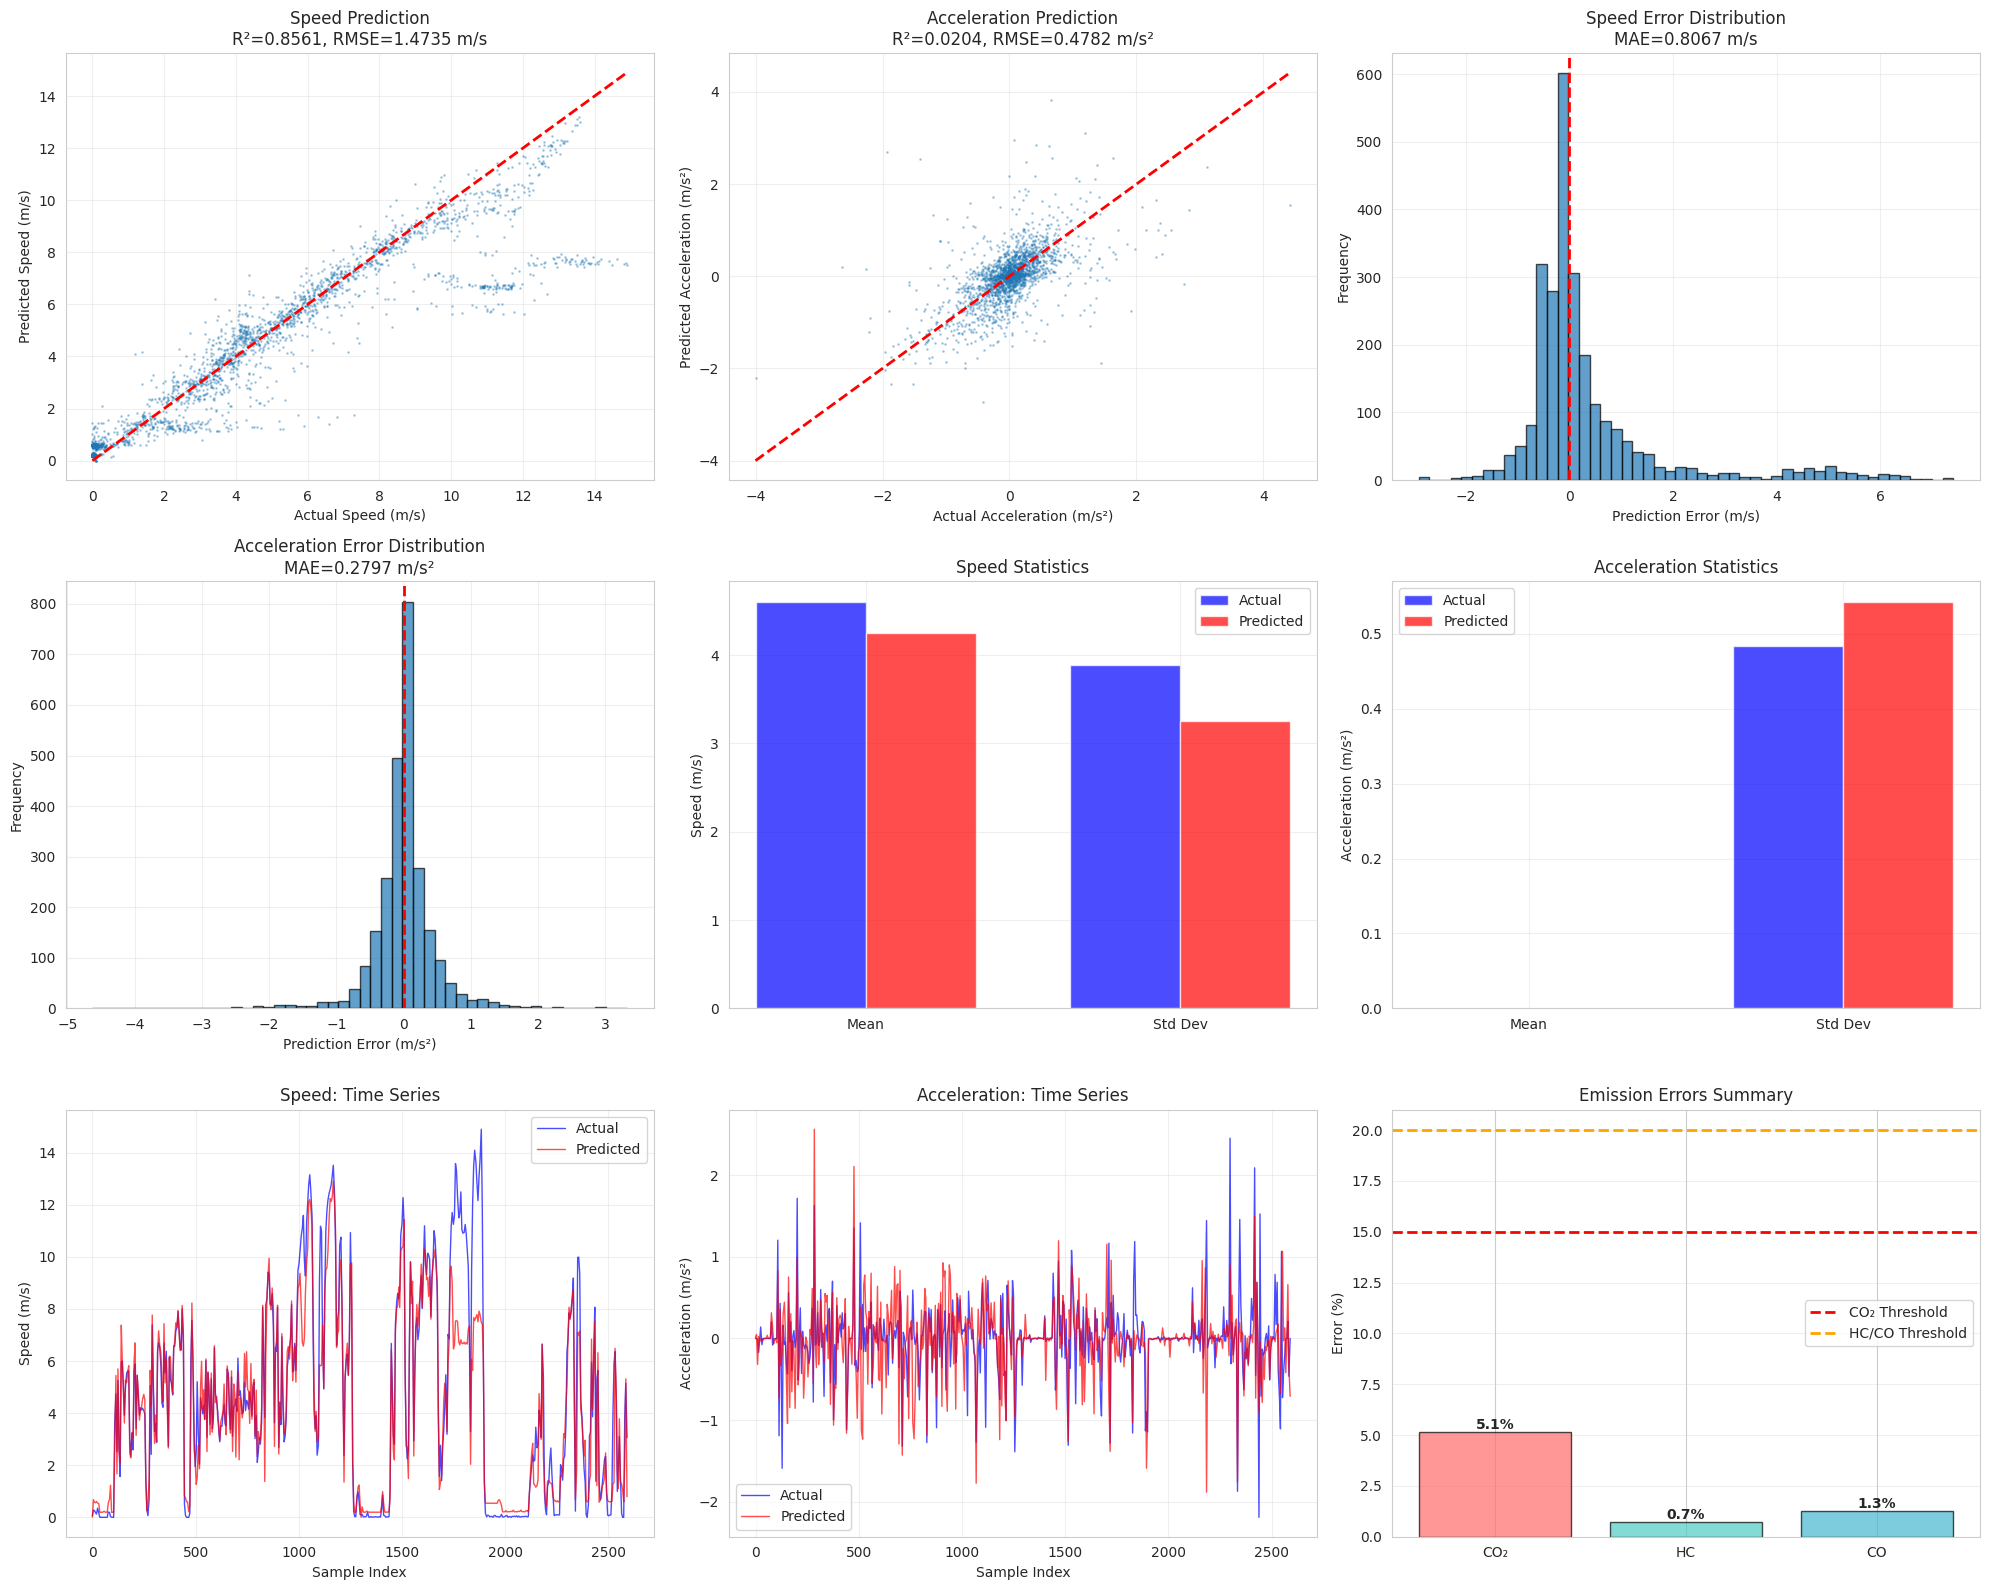

✅ Traditional plots generated


In [13]:
# CELL 10: Create Traditional Validation Plots
print("\nGenerating traditional validation plots...")

fig1 = plt.figure(figsize=(20, 16))

# Plot 1: Speed Scatter
plt.subplot(3, 3, 1)
plt.scatter(y_test_speed, y_pred_speed, alpha=0.3, s=1)
plt.plot([y_test_speed.min(), y_test_speed.max()], 
         [y_test_speed.min(), y_test_speed.max()], 'r--', lw=2)
plt.xlabel('Actual Speed (m/s)')
plt.ylabel('Predicted Speed (m/s)')
plt.title(f'Speed Prediction\nR²={speed_r2:.4f}, RMSE={speed_rmse:.4f} m/s')
plt.grid(True, alpha=0.3)

# Plot 2: Acceleration Scatter
plt.subplot(3, 3, 2)
plt.scatter(y_test_accel, y_pred_accel, alpha=0.3, s=1)
plt.plot([y_test_accel.min(), y_test_accel.max()], 
         [y_test_accel.min(), y_test_accel.max()], 'r--', lw=2)
plt.xlabel('Actual Acceleration (m/s²)')
plt.ylabel('Predicted Acceleration (m/s²)')
plt.title(f'Acceleration Prediction\nR²={accel_r2:.4f}, RMSE={accel_rmse:.4f} m/s²')
plt.grid(True, alpha=0.3)

# Plot 3: Speed Error Distribution
plt.subplot(3, 3, 3)
speed_errors = y_test_speed - y_pred_speed
plt.hist(speed_errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Prediction Error (m/s)')
plt.ylabel('Frequency')
plt.title(f'Speed Error Distribution\nMAE={speed_mae:.4f} m/s')
plt.grid(True, alpha=0.3)

# Plot 4: Acceleration Error Distribution
plt.subplot(3, 3, 4)
accel_errors = y_test_accel - y_pred_accel
plt.hist(accel_errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Prediction Error (m/s²)')
plt.ylabel('Frequency')
plt.title(f'Acceleration Error Distribution\nMAE={accel_mae:.4f} m/s²')
plt.grid(True, alpha=0.3)

# Plot 5: Speed Statistics
plt.subplot(3, 3, 5)
categories = ['Mean', 'Std Dev']
actual_vals = [speed_mean_actual, speed_std_actual]
pred_vals = [speed_mean_pred, speed_std_pred]
x = np.arange(len(categories))
width = 0.35
plt.bar(x - width/2, actual_vals, width, label='Actual', color='blue', alpha=0.7)
plt.bar(x + width/2, pred_vals, width, label='Predicted', color='red', alpha=0.7)
plt.ylabel('Speed (m/s)')
plt.title('Speed Statistics')
plt.xticks(x, categories)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Acceleration Statistics
plt.subplot(3, 3, 6)
actual_vals = [accel_mean_actual, accel_std_actual]
pred_vals = [accel_mean_pred, accel_std_pred]
plt.bar(x - width/2, actual_vals, width, label='Actual', color='blue', alpha=0.7)
plt.bar(x + width/2, pred_vals, width, label='Predicted', color='red', alpha=0.7)
plt.ylabel('Acceleration (m/s²)')
plt.title('Acceleration Statistics')
plt.xticks(x, categories)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 7: Speed Time Series
plt.subplot(3, 3, 7)
sample_size = min(500, len(y_test_speed))
sample_idx = np.linspace(0, len(y_test_speed)-1, sample_size).astype(int)
plt.plot(sample_idx, y_test_speed[sample_idx], 'b-', alpha=0.7, label='Actual', linewidth=1)
plt.plot(sample_idx, y_pred_speed[sample_idx], 'r-', alpha=0.7, label='Predicted', linewidth=1)
plt.xlabel('Sample Index')
plt.ylabel('Speed (m/s)')
plt.title('Speed: Time Series')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 8: Acceleration Time Series
plt.subplot(3, 3, 8)
plt.plot(sample_idx, y_test_accel[sample_idx], 'b-', alpha=0.7, label='Actual', linewidth=1)
plt.plot(sample_idx, y_pred_accel[sample_idx], 'r-', alpha=0.7, label='Predicted', linewidth=1)
plt.xlabel('Sample Index')
plt.ylabel('Acceleration (m/s²)')
plt.title('Acceleration: Time Series')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 9: Multi-Gas Emission Errors
plt.subplot(3, 3, 9)
gases = ['CO₂', 'HC', 'CO']
errors = [
    emission_metrics['co2']['error_percent'],
    emission_metrics['hc']['error_percent'],
    emission_metrics['co']['error_percent']
]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = plt.bar(gases, errors, color=colors, alpha=0.7, edgecolor='black')
plt.axhline(y=15, color='r', linestyle='--', linewidth=2, label='CO₂ Threshold')
plt.axhline(y=20, color='orange', linestyle='--', linewidth=2, label='HC/CO Threshold')
plt.ylabel('Error (%)')
plt.title('Emission Errors Summary')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

for bar, error in zip(bars, errors):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{error:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Traditional plots generated")

## Emission Time Series Plots - One per Cell for Maximum Clarity


=== Generating CO2 Emission Comparison ===


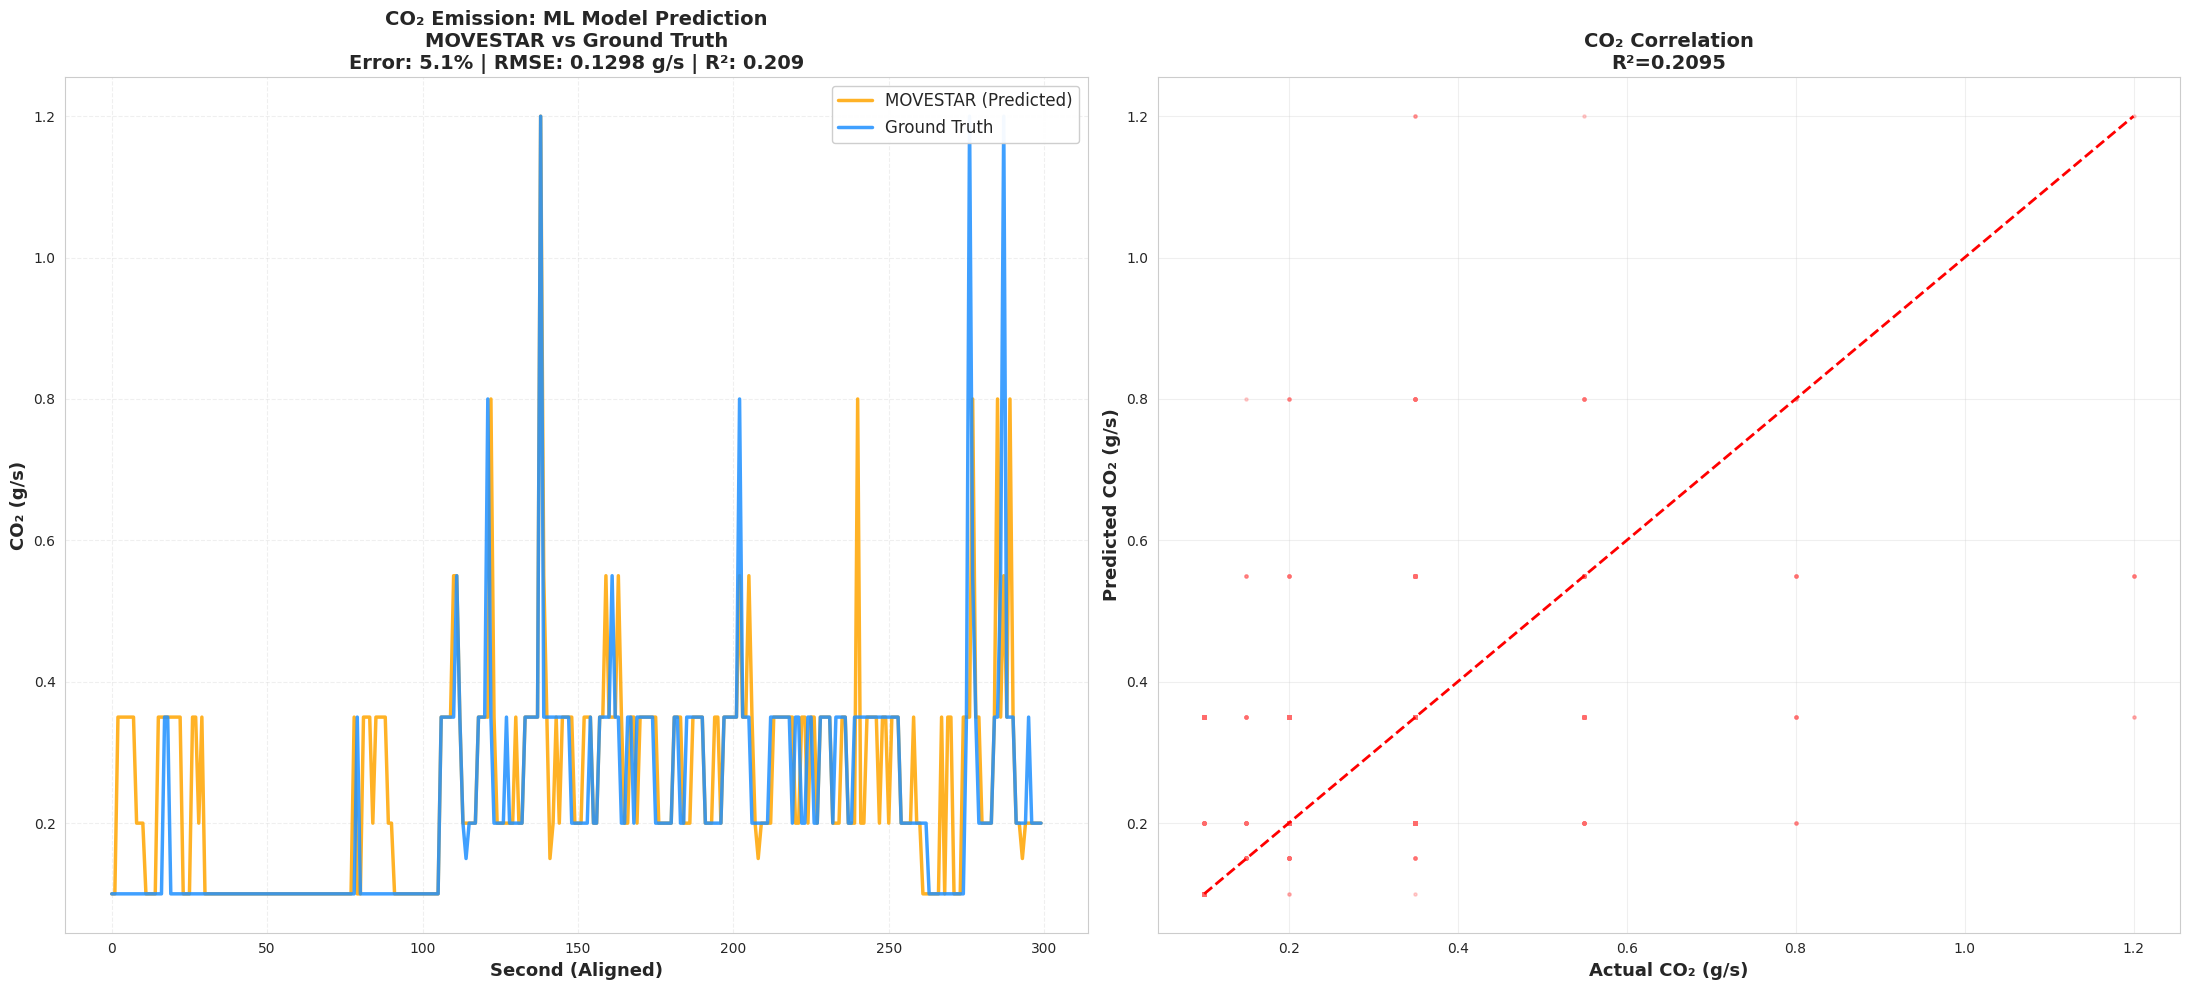

✅ CO2 emission plot generated


In [14]:
# CELL 11: CO2 Emission Time Series Plot
print("\n=== Generating CO2 Emission Comparison ===")

fig_co2 = plt.figure(figsize=(22, 10))

# Time series
plt.subplot(1, 2, 1)
plot_length = min(300, len(emissions_actual['co2']))
time_seconds = np.arange(plot_length)

plt.plot(time_seconds, emissions_pred['co2'][:plot_length], 
         color='orange', linewidth=2.5, label='MOVESTAR (Predicted)', alpha=0.85)
plt.plot(time_seconds, emissions_actual['co2'][:plot_length], 
         color='dodgerblue', linewidth=2.5, label='Ground Truth', alpha=0.85)

co2_m = emission_metrics['co2']
plt.xlabel('Second (Aligned)', fontsize=13, fontweight='bold')
plt.ylabel('CO₂ (g/s)', fontsize=13, fontweight='bold')
plt.title(
    f'CO₂ Emission: ML Model Prediction\n'
    f'MOVESTAR vs Ground Truth\n'
    f'Error: {co2_m["error_percent"]:.1f}% | RMSE: {co2_m["rmse_gs"]:.4f} g/s | R²: {co2_m["r2_score"]:.3f}',
    fontsize=14, fontweight='bold'
)
plt.legend(loc='upper right', fontsize=12, framealpha=0.95)
plt.grid(True, alpha=0.3, linestyle='--')

# Scatter
plt.subplot(1, 2, 2)
plt.scatter(emissions_actual['co2'], emissions_pred['co2'], alpha=0.3, s=5, c='#FF6B6B')
plt.plot([emissions_actual['co2'].min(), emissions_actual['co2'].max()], 
         [emissions_actual['co2'].min(), emissions_actual['co2'].max()], 'r--', lw=2)
plt.xlabel('Actual CO₂ (g/s)', fontsize=13, fontweight='bold')
plt.ylabel('Predicted CO₂ (g/s)', fontsize=13, fontweight='bold')
plt.title(f'CO₂ Correlation\nR²={co2_m["r2_score"]:.4f}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ CO2 emission plot generated")


=== Generating HC Emission Comparison ===


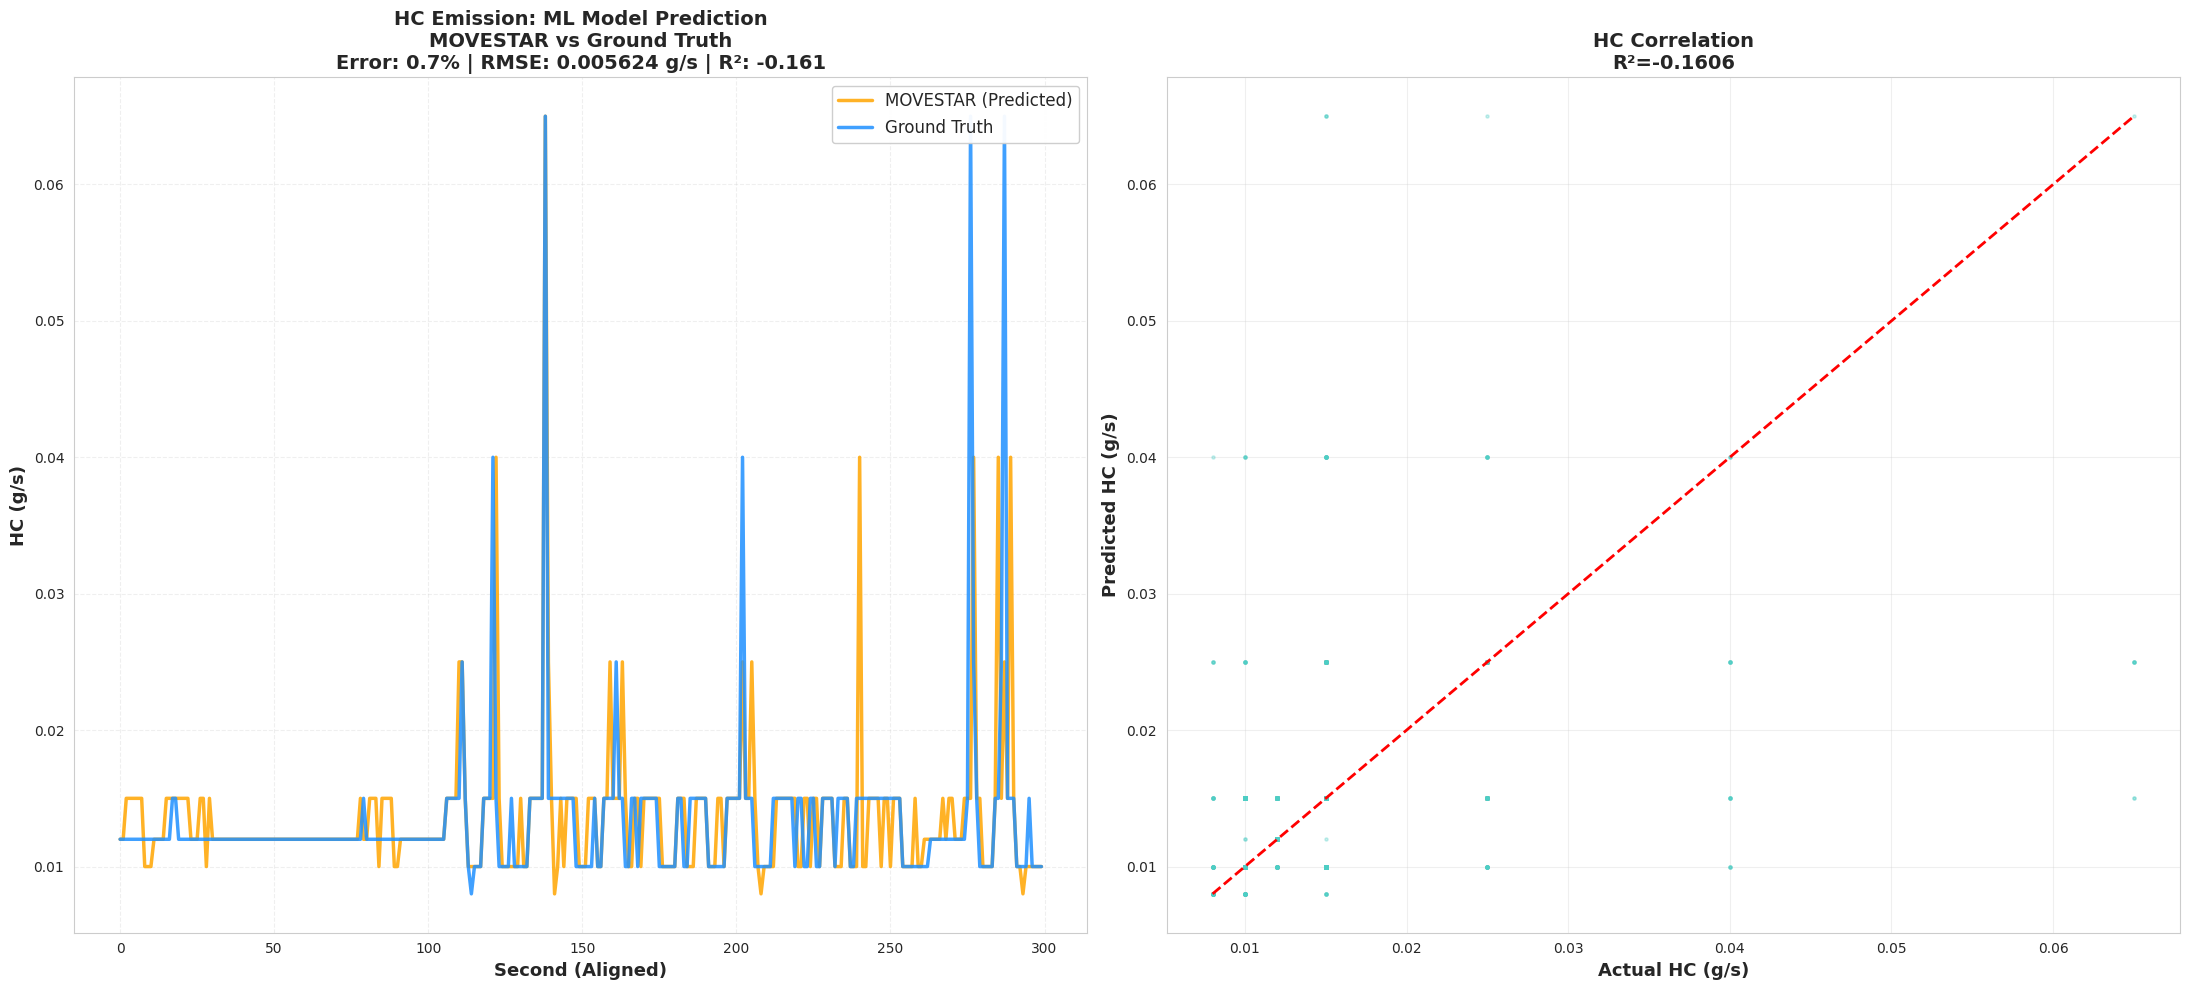

✅ HC emission plot generated


In [15]:
# CELL 12: HC Emission Time Series Plot
print("\n=== Generating HC Emission Comparison ===")

fig_hc = plt.figure(figsize=(22, 10))

# Time series
plt.subplot(1, 2, 1)
plot_length = min(300, len(emissions_actual['hc']))
time_seconds = np.arange(plot_length)

plt.plot(time_seconds, emissions_pred['hc'][:plot_length], 
         color='orange', linewidth=2.5, label='MOVESTAR (Predicted)', alpha=0.85)
plt.plot(time_seconds, emissions_actual['hc'][:plot_length], 
         color='dodgerblue', linewidth=2.5, label='Ground Truth', alpha=0.85)

hc_m = emission_metrics['hc']
plt.xlabel('Second (Aligned)', fontsize=13, fontweight='bold')
plt.ylabel('HC (g/s)', fontsize=13, fontweight='bold')
plt.title(
    f'HC Emission: ML Model Prediction\n'
    f'MOVESTAR vs Ground Truth\n'
    f'Error: {hc_m["error_percent"]:.1f}% | RMSE: {hc_m["rmse_gs"]:.6f} g/s | R²: {hc_m["r2_score"]:.3f}',
    fontsize=14, fontweight='bold'
)
plt.legend(loc='upper right', fontsize=12, framealpha=0.95)
plt.grid(True, alpha=0.3, linestyle='--')

# Scatter
plt.subplot(1, 2, 2)
plt.scatter(emissions_actual['hc'], emissions_pred['hc'], alpha=0.3, s=5, c='#4ECDC4')
plt.plot([emissions_actual['hc'].min(), emissions_actual['hc'].max()], 
         [emissions_actual['hc'].min(), emissions_actual['hc'].max()], 'r--', lw=2)
plt.xlabel('Actual HC (g/s)', fontsize=13, fontweight='bold')
plt.ylabel('Predicted HC (g/s)', fontsize=13, fontweight='bold')
plt.title(f'HC Correlation\nR²={hc_m["r2_score"]:.4f}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ HC emission plot generated")


=== Generating CO Emission Comparison ===


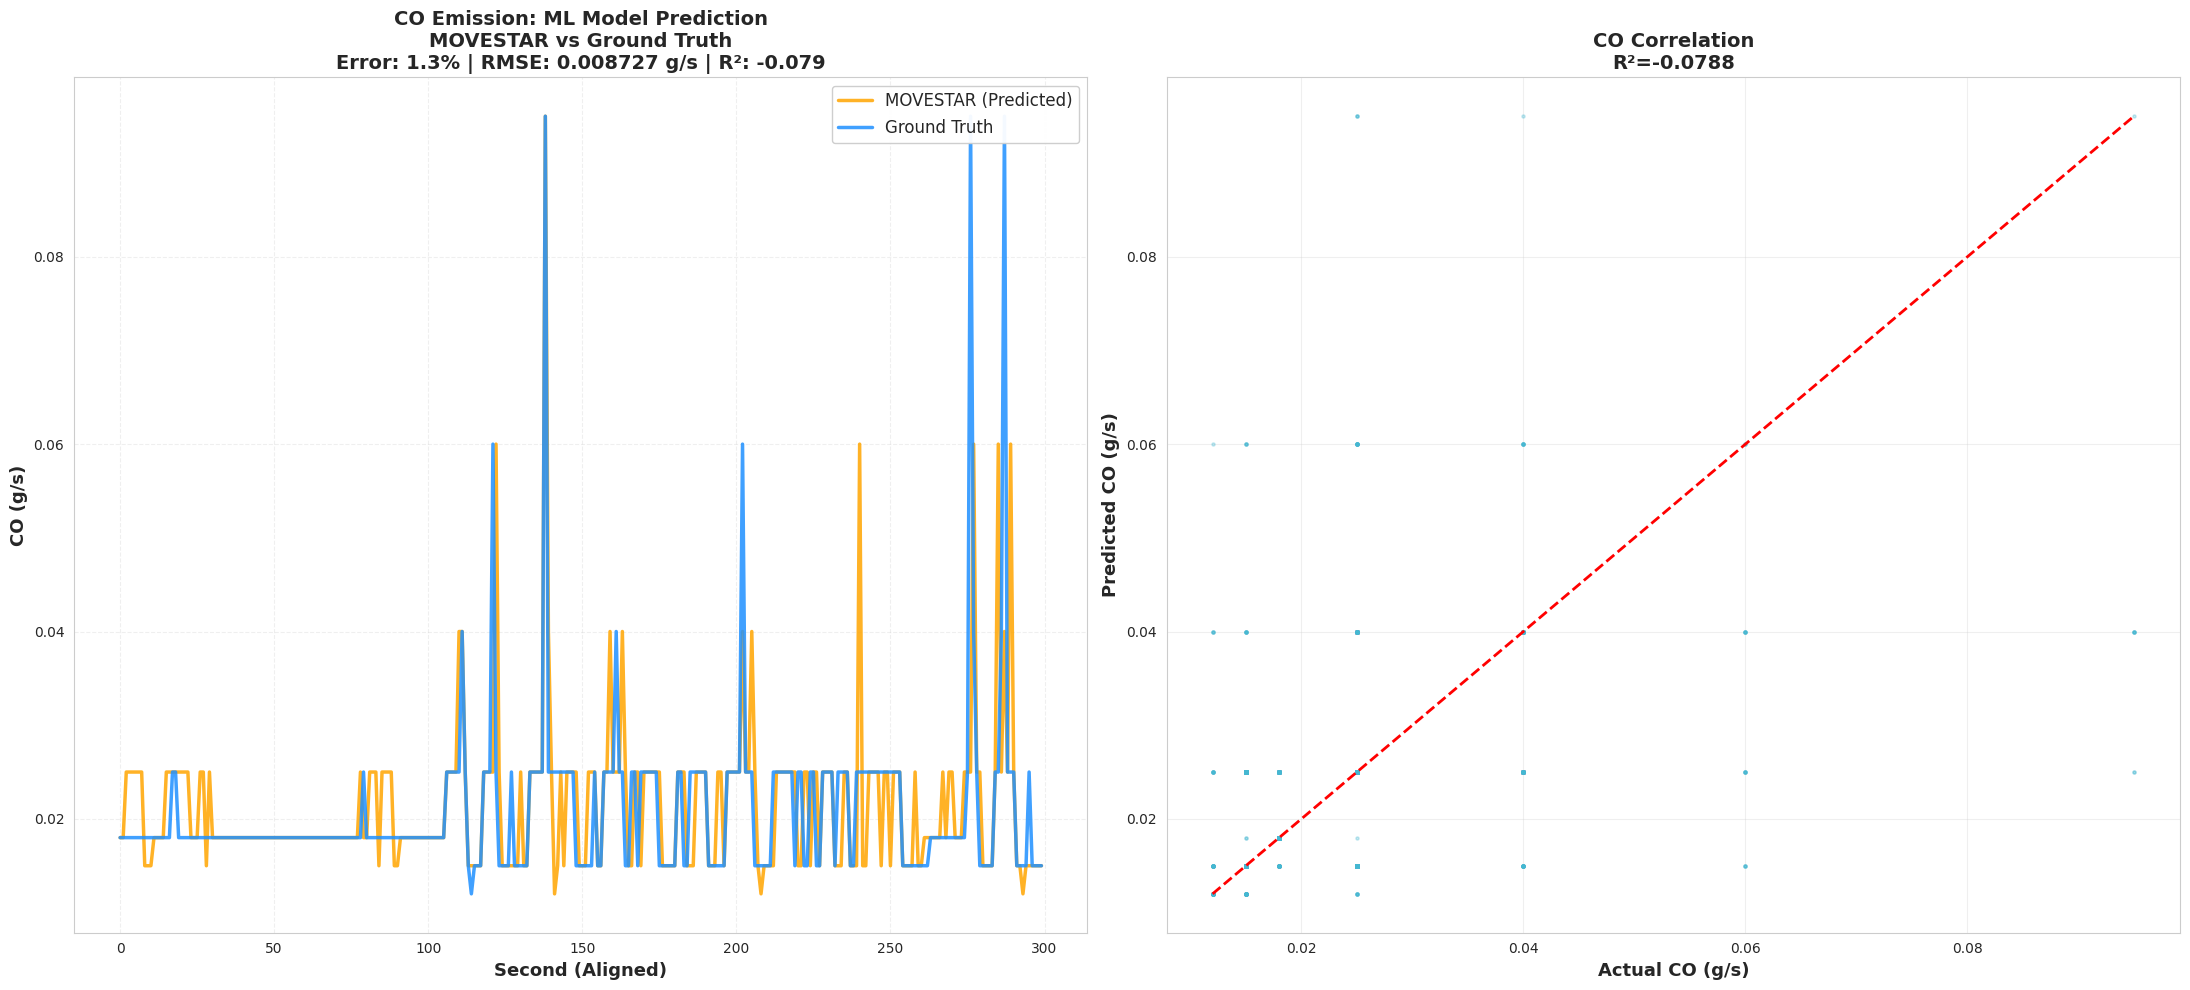

✅ CO emission plot generated


In [16]:
# CELL 13: CO Emission Time Series Plot
print("\n=== Generating CO Emission Comparison ===")

fig_co = plt.figure(figsize=(22, 10))

# Time series
plt.subplot(1, 2, 1)
plot_length = min(300, len(emissions_actual['co']))
time_seconds = np.arange(plot_length)

plt.plot(time_seconds, emissions_pred['co'][:plot_length], 
         color='orange', linewidth=2.5, label='MOVESTAR (Predicted)', alpha=0.85)
plt.plot(time_seconds, emissions_actual['co'][:plot_length], 
         color='dodgerblue', linewidth=2.5, label='Ground Truth', alpha=0.85)

co_m = emission_metrics['co']
plt.xlabel('Second (Aligned)', fontsize=13, fontweight='bold')
plt.ylabel('CO (g/s)', fontsize=13, fontweight='bold')
plt.title(
    f'CO Emission: ML Model Prediction\n'
    f'MOVESTAR vs Ground Truth\n'
    f'Error: {co_m["error_percent"]:.1f}% | RMSE: {co_m["rmse_gs"]:.6f} g/s | R²: {co_m["r2_score"]:.3f}',
    fontsize=14, fontweight='bold'
)
plt.legend(loc='upper right', fontsize=12, framealpha=0.95)
plt.grid(True, alpha=0.3, linestyle='--')

# Scatter
plt.subplot(1, 2, 2)
plt.scatter(emissions_actual['co'], emissions_pred['co'], alpha=0.3, s=5, c='#45B7D1')
plt.plot([emissions_actual['co'].min(), emissions_actual['co'].max()], 
         [emissions_actual['co'].min(), emissions_actual['co'].max()], 'r--', lw=2)
plt.xlabel('Actual CO (g/s)', fontsize=13, fontweight='bold')
plt.ylabel('Predicted CO (g/s)', fontsize=13, fontweight='bold')
plt.title(f'CO Correlation\nR²={co_m["r2_score"]:.4f}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ CO emission plot generated")

In [ ]:
# CELL 14.5a: VSP Metrics Summary (Text Output)
print("\n=== VSP METRICS SUMMARY ===")
print("=" * 40)

# 1. Accuracy Metrics
print("Accuracy Metrics:")
print(f"  RMSE:  {vsp_rmse:.4f} kW/ton ⭐")
print(f"  MAE:   {vsp_mae:.4f} kW/ton")
print(f"  R²:    {vsp_r2:.4f}")
print(f"  MAPE:  {vsp_mape:.2f}%")

# 2. Statistical Comparison
print("\nStatistical Comparison:")
print("  Mean:")
print(f"    Actual:    {vsp_mean_actual:.4f} kW/ton")
print(f"    Predicted: {vsp_mean_pred:.4f} kW/ton")
print(f"    Difference: {abs(vsp_mean_actual - vsp_mean_pred):.4f}")
print("  Std Dev:")
print(f"    Actual:    {vsp_std_actual:.4f} kW/ton")
print(f"    Predicted: {vsp_std_pred:.4f} kW/ton")

# 3. Status Check
print("\nQuality Check:")
print(f"  Vehicle Type: {VEHICLE_TYPE_VSP.capitalize()}")
print(f"  Threshold: {MAX_VSP_RMSE:.2f} kW/ton")
status_icon = '✅ PASS' if vsp_rmse <= MAX_VSP_RMSE else '❌ FAIL'
print(f"  Status: {status_icon}")
print("=" * 40)

In [ ]:
# CELL 14.5b: VSP Main Visualization (Time Series & Correlation)
import matplotlib.pyplot as plt

# Tentukan sample plot agar tidak terlalu berat
plot_length = min(500, len(vsp_actual))

print("=== 1. VSP Time Series Comparison ===")
plt.figure(figsize=(14, 6))
plt.plot(vsp_actual[:plot_length], 'b-', linewidth=2, label='Actual VSP', alpha=0.8)
plt.plot(vsp_predicted[:plot_length], 'r-', linewidth=2, label='Predicted VSP', alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
plt.xlabel('Time (seconds)', fontweight='bold')
plt.ylabel('VSP (kW/ton)', fontweight='bold')
plt.title(f'VSP Time Series (First {plot_length} samples)\nRMSE={vsp_rmse:.4f}', fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

print("=== 2. VSP Scatter (Correlation) ===")
plt.figure(figsize=(8, 8))
plt.scatter(vsp_actual, vsp_predicted, alpha=0.3, s=5, c='green', edgecolors='none')
# Garis perfect prediction
min_vsp = min(vsp_actual.min(), vsp_predicted.min())
max_vsp = max(vsp_actual.max(), vsp_predicted.max())
plt.plot([min_vsp, max_vsp], [min_vsp, max_vsp], 'r--', linewidth=2.5, label='Perfect Prediction')
plt.xlabel('Actual VSP (kW/ton)', fontweight='bold')
plt.ylabel('Predicted VSP (kW/ton)', fontweight='bold')
plt.title(f'VSP Correlation Plot\nR²={vsp_r2:.4f}', fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

print("=== 3. VSP Error Distribution ===")
plt.figure(figsize=(10, 6))
vsp_errors = vsp_actual - vsp_predicted
plt.hist(vsp_errors, bins=50, edgecolor='black', alpha=0.7, color='green')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2.5, label='Zero Error')
plt.axvline(x=vsp_errors.mean(), color='orange', linestyle='-', linewidth=2, 
            label=f'Mean={vsp_errors.mean():.4f}')
plt.xlabel('VSP Error (kW/ton)', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title(f'VSP Error Distribution Histogram\nStd Dev={vsp_errors.std():.4f}', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

In [ ]:
# CELL 14.5c: VSP Physics Analysis & Residuals

print("=== 4. VSP Statistics Comparison (Bar Chart) ===")
plt.figure(figsize=(10, 6))
categories = ['Mean', 'Std Dev', 'Min', 'Max']
actual_vals = [vsp_mean_actual, vsp_std_actual, vsp_actual.min(), vsp_actual.max()]
pred_vals = [vsp_mean_pred, vsp_std_pred, vsp_predicted.min(), vsp_predicted.max()]
x = np.arange(len(categories))
width = 0.35
plt.bar(x - width/2, actual_vals, width, label='Actual', color='blue', alpha=0.7)
plt.bar(x + width/2, pred_vals, width, label='Predicted', color='red', alpha=0.7)
plt.ylabel('VSP (kW/ton)', fontweight='bold')
plt.title('Statistics Comparison: Actual vs Predicted', fontweight='bold')
plt.xticks(x, categories)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

# Sample random points for physics plots
sample_idx = np.random.choice(len(vsp_actual), min(1000, len(vsp_actual)), replace=False)

print("=== 5. Physics Check: VSP vs Speed ===")
plt.figure(figsize=(10, 6))
plt.scatter(y_test_speed[sample_idx], vsp_actual[sample_idx], alpha=0.3, s=10, 
            c='blue', label='Actual', edgecolors='none')
plt.scatter(y_pred_speed[sample_idx], vsp_predicted[sample_idx], alpha=0.3, s=10, 
            c='red', label='Predicted', edgecolors='none')
plt.xlabel('Speed (m/s)', fontweight='bold')
plt.ylabel('VSP (kW/ton)', fontweight='bold')
plt.title('Relationship: VSP vs Speed', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("=== 6. Physics Check: VSP vs Acceleration ===")
plt.figure(figsize=(10, 6))
plt.scatter(y_test_accel[sample_idx], vsp_actual[sample_idx], alpha=0.3, s=10, 
            c='blue', label='Actual', edgecolors='none')
plt.scatter(y_pred_accel[sample_idx], vsp_predicted[sample_idx], alpha=0.3, s=10, 
            c='red', label='Predicted', edgecolors='none')
plt.xlabel('Acceleration (m/s²)', fontweight='bold')
plt.ylabel('VSP (kW/ton)', fontweight='bold')
plt.title('Relationship: VSP vs Acceleration', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("=== 7. VSP Residuals & Cumulative Error ===")
plt.figure(figsize=(14, 8))

# Residuals (Atas)
plt.subplot(2, 1, 1)
plt.plot(vsp_errors[:plot_length], 'g-', alpha=0.5, linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.axhline(y=vsp_mae, color='orange', linestyle=':', linewidth=1, label=f'MAE={vsp_mae:.4f}')
plt.axhline(y=-vsp_mae, color='orange', linestyle=':', linewidth=1)
plt.ylabel('VSP Error (kW/ton)', fontweight='bold')
plt.title('Prediction Errors Over Time', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Cumulative (Bawah)
plt.subplot(2, 1, 2)
cumulative_error = np.cumsum(np.abs(vsp_errors))
plt.plot(cumulative_error[:plot_length], 'purple', linewidth=2)
plt.xlabel('Time (seconds)', fontweight='bold')
plt.ylabel('Cumulative Abs Error', fontweight='bold')
plt.title('Cumulative Error Growth', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# CELL 14: Evaluate Pass/Fail & Save Results (Raw Autoregressive Performance)
print("\n=== QUALITY EVALUATION (Unshifted) ===")

# Helper function to convert numpy types to Python native
def convert_to_native(obj):
    """Convert numpy types to Python native types for JSON serialization."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_native(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native(item) for item in obj]
    else:
        return obj

# Compile metrics using raw variables from Cells 8 and 9
metrics = {
    "model_name": model_name,
    "run_timestamp": RUN_TIMESTAMP,
    "test_samples": int(len(y_test_speed)),
    "vehicle_type": "Motorcycle" if VEHICLE_TYPE == 1 else "Car",
    "acceleration_method": "speed_difference",
    "speed": {
        "r2_score": float(speed_r2),
        "rmse_ms": float(speed_rmse),
        "rmse_kmh": float(speed_rmse * 3.6),
        "mae_ms": float(speed_mae),
        "mae_kmh": float(speed_mae * 3.6),
        "mse": float(speed_mse),
        "mape_percent": float(speed_mape),
        "mean_actual": float(speed_mean_actual),
        "mean_predicted": float(speed_mean_pred),
        "std_actual": float(speed_std_actual),
        "std_predicted": float(speed_std_pred)
    },
    "acceleration": {
        "r2_score": float(accel_r2),
        "rmse": float(accel_rmse),
        "mae": float(accel_mae),
        "mse": float(accel_mse),
        "mape_percent": float(accel_mape),
        "mean_actual": float(accel_mean_actual),
        "mean_predicted": float(accel_mean_pred),
        "std_actual": float(accel_std_actual),
        "std_predicted": float(accel_std_pred)
    },
    "emissions": convert_to_native(emission_metrics),
    "time_shift_correction": {"applied": False, "shift_seconds": 0},
    "vsp": {
        "r2_score": float(vsp_r2),
        "rmse": float(vsp_rmse),
        "mae": float(vsp_mae),
        "mse": float(vsp_mse),
        "mape_percent": float(vsp_mape),
        "mean_actual": float(vsp_mean_actual),
        "mean_predicted": float(vsp_mean_pred),
        "std_actual": float(vsp_std_actual),
        "std_predicted": float(vsp_std_pred)
    },
    "thresholds": {
        "min_r2_score": float(MIN_R2_SCORE),
        "max_speed_rmse_ms": float(MAX_SPEED_RMSE),
        "max_accel_rmse": float(MAX_ACCEL_RMSE),
        "max_speed_mae_ms": float(MAX_SPEED_MAE),
        "max_accel_mae": float(MAX_ACCEL_MAE),
        "max_co2_error_percent": float(MAX_CO2_ERROR_PERCENT),
        "max_hc_error_percent": float(MAX_HC_ERROR_PERCENT),
        "max_co_error_percent": float(MAX_CO_ERROR_PERCENT),  # <-- SUDAH DIPERBAIKI (ADA KOMA)
        "max_vsp_rmse": float(MAX_VSP_RMSE),
        "vehicle_type_vsp": VEHICLE_TYPE_VSP
    }
}

# Determine pass/fail
failures = []
if speed_r2 < MIN_R2_SCORE:
    failures.append(f"Speed R² {speed_r2:.4f} < {MIN_R2_SCORE}")
if speed_rmse > MAX_SPEED_RMSE:
    failures.append(f"Speed RMSE {speed_rmse:.4f} > {MAX_SPEED_RMSE} m/s")
if speed_mae > MAX_SPEED_MAE:
    failures.append(f"Speed MAE {speed_mae:.4f} > {MAX_SPEED_MAE} m/s")
if accel_rmse > MAX_ACCEL_RMSE:
    failures.append(f"Acceleration RMSE {accel_rmse:.4f} > {MAX_ACCEL_RMSE} m/s²")
if accel_mae > MAX_ACCEL_MAE:
    failures.append(f"Acceleration MAE {accel_mae:.4f} > {MAX_ACCEL_MAE} m/s²")
if emission_metrics['co2']['error_percent'] > MAX_CO2_ERROR_PERCENT:
    failures.append(f"CO2 error {emission_metrics['co2']['error_percent']:.2f}% > {MAX_CO2_ERROR_PERCENT}%")
if emission_metrics['hc']['error_percent'] > MAX_HC_ERROR_PERCENT:
    failures.append(f"HC error {emission_metrics['hc']['error_percent']:.2f}% > {MAX_HC_ERROR_PERCENT}%")
if emission_metrics['co']['error_percent'] > MAX_CO_ERROR_PERCENT:
    failures.append(f"CO error {emission_metrics['co']['error_percent']:.2f}% > {MAX_CO_ERROR_PERCENT}%")
# VSP threshold check
if vsp_rmse > MAX_VSP_RMSE:
    failures.append(f"VSP RMSE {vsp_rmse:.4f} > {MAX_VSP_RMSE} kW/ton")


metrics["validation_passed"] = len(failures) == 0
metrics["failures"] = failures

# Convert entire metrics dict
metrics = convert_to_native(metrics)

print(json.dumps(metrics, indent=2))

# Save plots
print("\n=== Saving Results ===")
def save_fig_to_s3(fig, path):
    img_buf = io.BytesIO()
    fig.savefig(img_buf, format='png', dpi=150, bbox_inches='tight')
    img_buf.seek(0)
    with fs.open(path, 'wb') as f:
        f.write(img_buf.getbuffer())

save_fig_to_s3(fig1, OUTPUT_PLOT_PATH)
save_fig_to_s3(fig_co2, OUTPUT_CO2_PLOT_PATH)
save_fig_to_s3(fig_hc, OUTPUT_HC_PLOT_PATH)
save_fig_to_s3(fig_co, OUTPUT_CO_PLOT_PATH)

with fs.open(OUTPUT_METRICS_PATH, 'w') as f:
    json.dump(metrics, f, indent=2)

# Final summary printing
if failures:
    print(f"\n⚠️  Model Quality Validation Failed ({len(failures)} issues):")
    for failure in failures:
        print(f"  - {failure}")
else:
    print("\n✅ Model Quality Validation Passed!")

print("\n" + "="*70)
print("🎉 VALIDATION COMPLETE WITH MULTI-GAS EMISSIONS (Raw Predictions)")
print("="*70)
print(f"Model: {model_name}")
print(f"Vehicle Type: {VEHICLE_TYPE_VSP}")
print(f"\nPerformance Summary:")
print(f"  Speed:  R²={speed_r2:.4f} | RMSE={speed_rmse:.4f} m/s")
print(f"  Accel:  R²={accel_r2:.4f} | RMSE={accel_rmse:.4f} m/s²")
print(f"  VSP:    R²={vsp_r2:.4f} | RMSE={vsp_rmse:.4f} kW/ton ⭐")
print(f"\nSpeed R²: {speed_r2:.4f} | RMSE: {speed_rmse:.4f} m/s")
print(f"Accel R²: {accel_r2:.4f} | RMSE: {accel_rmse:.4f} m/s²")
print(f"\n🔥 Raw Emission Errors:")
for gas in ['co2', 'hc', 'co']:
    em = emission_metrics[gas]
    status = "✅" if em['r2_score'] > 0.7 else "⚙️" if em['r2_score'] > 0.5 else "⚠️"
    print(f"  {gas.upper()}: Error={em['error_percent']:.1f}% | R²={em['r2_score']:.3f} {status}")
print("="*70)


=== QUALITY EVALUATION (Unshifted) ===
{
  "model_name": "XGBoost",
  "run_timestamp": "2025-12-07_07-13-20",
  "test_samples": 2591,
  "vehicle_type": "Motorcycle",
  "acceleration_method": "speed_difference",
  "speed": {
    "r2_score": 0.8560842940947568,
    "rmse_ms": 1.4734899545952584,
    "rmse_kmh": 5.304563836542931,
    "mae_ms": 0.806690743475659,
    "mae_kmh": 2.9040866765123723,
    "mse": 2.171172646293137,
    "mape_percent": 1.9255508460420415e+40,
    "mean_actual": 4.602964962802235,
    "mean_predicted": 4.247651043947569,
    "std_actual": 3.884123973813831,
    "std_predicted": 3.253129449631045
  },
  "acceleration": {
    "r2_score": 0.020429042869914538,
    "rmse": 0.47821885627028654,
    "mae": 0.2797209972488795,
    "mse": 0.22869327449246096,
    "mape_percent": 102323.56545732707,
    "mean_actual": 0.001160211068148328,
    "mean_predicted": 0.0003055370438287544,
    "std_actual": 0.48317977386697547,
    "std_predicted": 0.5426394086522479
  },
  "


✅ Model Quality Validation Passed!

🎉 VALIDATION COMPLETE WITH MULTI-GAS EMISSIONS (Raw Predictions)
Model: XGBoost

Speed R²: 0.8561 | RMSE: 1.4735 m/s
Accel R²: 0.0204 | RMSE: 0.4782 m/s²

🔥 Raw Emission Errors:
  CO2: Error=5.1% | R²=0.209 ⚠️
  HC: Error=0.7% | R²=-0.161 ⚠️
  CO: Error=1.3% | R²=-0.079 ⚠️
